In [4]:
# Setup the environment
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# from skgstat import Variogram, OrdinaryKriging
# plt.style.use('ggplot')
os.environ['SKG_SUPPRESS'] = "true"

import geopandas
from shapely.geometry import Point

import random

In [5]:
root_dir = os.getcwd()

In [6]:
# download the meteorological data for interpolation
import zipfile
import urllib

EXTRACT_PATH = os.path.join(root_dir, 'data')
PATH = os.path.join("data", "zip")
URL_list = []
for i in range(2001,2020+1): # zmień rok na 2014 dla testu robiłem historyczne
    URL = "https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/miesieczne/klimat/%s/%s_m_k.zip" % (i, i)
    URL_list.append(URL)

def fetch_data(list_url=URL_list, housing_path=PATH, extract_path = EXTRACT_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    for url in list_url:
        tgz_path = os.path.join(housing_path, "m_k.zip")
        urllib.request.urlretrieve(url, tgz_path)
        housing_tgz = zipfile.ZipFile(tgz_path)
        housing_tgz.extractall(path=extract_path)
        housing_tgz.close()

In [7]:
fetch_data()

In [8]:
input_path = EXTRACT_PATH
files = [f for f in os.listdir(input_path) if f.endswith('.csv') if '_t' not in f]

In [9]:
files

['k_m_d_2011.csv',
 'k_m_d_2003.csv',
 'k_m_d_2001.csv',
 'k_m_d_2012.csv',
 'k_m_d_2017.csv',
 'k_m_d_2014.csv',
 'k_m_d_2007.csv',
 'k_m_d_2016.csv',
 'k_m_d_2008.csv',
 'k_m_d_2010.csv',
 'k_m_d_2013.csv',
 'k_m_d_2019.csv',
 'k_m_d_2005.csv',
 'k_m_d_2015.csv',
 'k_m_d_2002.csv',
 'k_m_d_2020.csv',
 'k_m_d_2006.csv',
 'k_m_d_2004.csv',
 'k_m_d_2009.csv',
 'k_m_d_2018.csv']

In [10]:
# Create a data frame with the data
data = pd.DataFrame()
col_names = ['kod_stacji', 'nazwa_stacji', 'rok', 'mies', 'abs_temp_maks', 'stat_TMAX', 'sr_temp_maks', 'stat_TMXS', 'abs_temp_min', 'stat_TMIN', 'sr_temp_min', 'stat_TMNS', 'sr_temp_mies', 'stat_STM', 'min_temp_grunt', 'stat_TMNG', 'mies_suma_opad', 'stat_SUMM', 'maks_dobowa_suma_opad', 'stat_OPMX', 'pierwszy_dzien_wyst_opad_maks', 'ost_dzien_wyst_opad_maks', 'maks_wys_pork_sniezn', 'stat_PKSN', 'liczba_dni_z_pokr_sniezna', 'liczba_dni_z_opadem_deszczu', 'liczba_dni_z_opadem_sniegu']
for file in files:
    data = pd.read_csv(os.path.join(input_path, file), encoding = 'latin1', 
                       sep = ',', 
                       names = col_names).append(data)

In [11]:
# Merge the data to get coordinates of meteorological stations
kod_meteo = pd.read_csv('wykaz_stacji_klimat.csv', 
            encoding = 'latin1', 
            sep = ';', 
            names = ['kod_stacji', 'kod_meteo', 'nazwa_stacji', 'E', 'N'],
                       header = 0)

In [12]:
data_stations = data.merge(kod_meteo, on = 'kod_stacji')

In [13]:
data_stations['stat_liczba'] = 0

In [14]:
# get the lists of variables and filter variables

variables = []
filt_variables = []
for i in data_stations.columns:
    if i.startswith('stat'):
        filt_variables.append(i)
        if 'stat_PKSN' in i:
            filt_variables.append(i)
            filt_variables.append(i)
    elif ('temp' in i) | ('_opad' in i) | ('wys_pokr_sniezn' in i):
        variables.append(i)
    if('liczba_dni' in i):
        variables.append(i)
        filt_variables.append('stat_liczba')

In [15]:
for i, j in zip(variables, filt_variables):
    print(i,'---filt by --->', j)

abs_temp_maks ---filt by ---> stat_TMAX
sr_temp_maks ---filt by ---> stat_TMXS
abs_temp_min ---filt by ---> stat_TMIN
sr_temp_min ---filt by ---> stat_TMNS
sr_temp_mies ---filt by ---> stat_STM
min_temp_grunt ---filt by ---> stat_TMNG
mies_suma_opad ---filt by ---> stat_SUMM
maks_dobowa_suma_opad ---filt by ---> stat_OPMX
pierwszy_dzien_wyst_opad_maks ---filt by ---> stat_PKSN
ost_dzien_wyst_opad_maks ---filt by ---> stat_PKSN
liczba_dni_z_pokr_sniezna ---filt by ---> stat_PKSN
liczba_dni_z_opadem_deszczu ---filt by ---> stat_liczba
liczba_dni_z_opadem_deszczu ---filt by ---> stat_liczba
liczba_dni_z_opadem_sniegu ---filt by ---> stat_liczba
liczba_dni_z_opadem_sniegu ---filt by ---> stat_liczba


In [16]:
# experimental points for interpolation
points = pd.read_csv('punkty_2.csv', 
                     sep = ';', 
                     encoding = 'latin1')[['Lokalizacja', 'E', 'N']]

In [17]:
# interpolation on the full data
import datetime
from dateutil.rrule import rrule, MONTHLY
from sklearn.model_selection import train_test_split
from scipy.stats import expon, reciprocal, uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


def rotate_coordinates(coordinates):
    '''Input coordinates as Data Frame, shape xx, 2 - columns E, N'''
    x_prim = pd.DataFrame()
    y_prim = pd.DataFrame()
    X_prim = pd.DataFrame()
    for i, angle in enumerate(np.deg2rad(range(0, 360, 2))): 
        x_val, y_val = np.array(coordinates.T)
        c, s = np.cos(angle), np.sin(angle)
        j = np.matrix([[c, s], [-s, c]])
        m = np.dot(j, [x_val, y_val])
        x_prim = pd.concat((x_prim, pd.DataFrame(m[0].T, columns = ['E_' + str(i)])), axis = 1)
        y_prim = pd.concat((y_prim, pd.DataFrame(m[1].T, columns = ['N_' + str(i)])), axis = 1)
        X_prim = pd.concat(
            (X_prim, 
            pd.DataFrame(m[0].T, columns = ['E_' + str(i)]), 
            pd.DataFrame(m[1].T, columns = ['N_' + str(i)])), axis = 1)
    return X_prim

def RMSE_test(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    return rmse

def interpolate_points(model, points):
    X_points = points[['E', 'N']]
    X_points_prim = rotate_coordinates(X_points)
    
    predicted = model.predict(X_points_prim)
    return predicted
    

def interpolate(data=data_stations, points = points, 
                variables = variables, 
                filt_variables = filt_variables):
    E_l = []
    N_l = []
    year_l = []
    month_l = []
    variable_l = []
    predictions_l = []
    
    strt_dt = datetime.date(2014,1,1)
    end_dt = datetime.date(2020,10,1)
#     end_dt = datetime.date(2015,3,1) # test variable

    for variable, filter_var in zip(variables, filt_variables):
        for single_date in rrule(MONTHLY, dtstart=strt_dt, until=end_dt):
            
            exception = False
            
            month = single_date.month
            year = single_date.year
            
            filt = ((data['mies']== month) & 
            (data['rok'] == year) & 
            (data[filter_var] != 8) & # filter out no measurement status 8 - no measurement
            (data[variable].notnull())) # filter out NaN values
            

            data_filtered = data[filt]

            X = data_filtered[['E', 'N']]
            y = data_filtered[variable]
            
            if y.size <= 10:
                print('empty y var')
            else:
            
                # data augmentation (rotate coordinates)
                X_prim = rotate_coordinates(X)

#                 # split the data
#                 try:
#                     X_train, X_test, y_train, y_test =  train_test_split(X_prim, y, test_size = 0.2, train_size = 0.8, random_state = 42, shuffle = True)
#                 except:
#                     print('split exception')

                # build and train the model
                param_distribs = {
                        'n_neighbors': randint(1,10),
                    }

                knr = KNeighborsRegressor(n_neighbors=10, 
                                          metric='euclidean', 
                                          weights= 'distance')
                knr_reg = RandomizedSearchCV(knr, param_distributions=param_distribs,
                                                n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                             n_jobs= -1, random_state = 42)
                try:
                    knr_reg.fit(X_prim, y)
                except:
                    exception = True

                if exception:
                    print('exception')
                else:
                    train_RMSE = RMSE_test(knr_reg, X_prim, y)
#                     test_RMSE = RMSE_test(knr_reg, X_test, y_test)
                    print(variable, year, month, 'train_RMSE:', train_RMSE)

                    # interpolate data points
                    predicted = interpolate_points(knr_reg, points)

                    predictions_l.extend(list(predicted))
                    E_l.extend(list(points['E']))
                    N_l.extend(list(points['N']))
                    year_l.extend([year for v, i in enumerate(predicted)])
                    month_l.extend([month for v, i in enumerate(predicted)])
                    variable_l.extend([variable for v, i in enumerate(predicted)])
        
        
    points_estimations = pd.DataFrame(columns = ['E', 'N', 'year', 'month', 'variable', 'predictions'])
    points_estimations['E'] =  E_l
    points_estimations['N'] = N_l
    points_estimations['year'] = year_l
    points_estimations['month'] = month_l
    points_estimations['variable'] = variable_l
    points_estimations['predictions'] = predictions_l
    
    return points_estimations

In [ ]:
full_estimations = interpolate()

abs_temp_maks 2014 1 train_RMSE: 7.617748803718519e-06
abs_temp_maks 2014 2 train_RMSE: 6.481201540711025e-06
abs_temp_maks 2014 3 train_RMSE: 1.191286671774288e-05
abs_temp_maks 2014 4 train_RMSE: 4.77219549091891e-06
abs_temp_maks 2014 5 train_RMSE: 7.030122059195681e-06
abs_temp_maks 2014 6 train_RMSE: 5.186768472742686e-06
abs_temp_maks 2014 7 train_RMSE: 3.540131776587435e-06
abs_temp_maks 2014 8 train_RMSE: 4.6899022557149195e-06
abs_temp_maks 2014 9 train_RMSE: 3.0902357221568534e-06
abs_temp_maks 2014 10 train_RMSE: 6.279563708621815e-06
abs_temp_maks 2014 11 train_RMSE: 5.719543501851473e-06
abs_temp_maks 2014 12 train_RMSE: 7.5220833992270836e-06
abs_temp_maks 2015 1 train_RMSE: 7.803733681813355e-06
abs_temp_maks 2015 2 train_RMSE: 4.965317936438635e-06
abs_temp_maks 2015 3 train_RMSE: 6.75011060869212e-06
abs_temp_maks 2015 4 train_RMSE: 5.21610870959849e-06
abs_temp_maks 2015 5 train_RMSE: 4.0578398848635575e-06
abs_temp_maks 2015 6 train_RMSE: 4.354087791594218e-06
abs_te

sr_temp_maks 2019 9 train_RMSE: 3.5572481934938035e-06
sr_temp_maks 2019 10 train_RMSE: 4.187445535508875e-06
sr_temp_maks 2019 11 train_RMSE: 3.8478809340271225e-06
sr_temp_maks 2019 12 train_RMSE: 4.992568621773618e-06
sr_temp_maks 2020 1 train_RMSE: 5.265192713359164e-06
sr_temp_maks 2020 2 train_RMSE: 5.2072728959619005e-06
sr_temp_maks 2020 3 train_RMSE: 4.215418139759339e-06
sr_temp_maks 2020 4 train_RMSE: 3.3342075346102447e-06
sr_temp_maks 2020 5 train_RMSE: 4.274465270623342e-06
sr_temp_maks 2020 6 train_RMSE: 4.869392240299726e-06
sr_temp_maks 2020 7 train_RMSE: 4.898493997776266e-06
sr_temp_maks 2020 8 train_RMSE: 4.339425893610527e-06
sr_temp_maks 2020 9 train_RMSE: 4.320829569895672e-06
sr_temp_maks 2020 10 train_RMSE: 4.28980023898315e-06
abs_temp_min 2014 1 train_RMSE: 1.0528267125506022e-05
abs_temp_min 2014 2 train_RMSE: 1.9158618806544114e-05
abs_temp_min 2014 3 train_RMSE: 1.669999719467971e-05
abs_temp_min 2014 4 train_RMSE: 1.1453725803911478e-05
abs_temp_min 2014 

sr_temp_min 2018 9 train_RMSE: 4.55624278063801e-06
sr_temp_min 2018 10 train_RMSE: 5.778042787420335e-06
sr_temp_min 2018 11 train_RMSE: 4.072736388087265e-06
sr_temp_min 2018 12 train_RMSE: 3.702384816766833e-06
sr_temp_min 2019 1 train_RMSE: 5.393543894495431e-06
sr_temp_min 2019 2 train_RMSE: 5.297552205691039e-06
sr_temp_min 2019 3 train_RMSE: 3.694717336550373e-06
sr_temp_min 2019 4 train_RMSE: 6.392723260058876e-06
sr_temp_min 2019 5 train_RMSE: 4.113566457761011e-06
sr_temp_min 2019 6 train_RMSE: 4.391992138003816e-06
sr_temp_min 2019 7 train_RMSE: 4.347981838135289e-06
sr_temp_min 2019 8 train_RMSE: 4.208338140036147e-06
sr_temp_min 2019 9 train_RMSE: 3.4316523236682722e-06
sr_temp_min 2019 10 train_RMSE: 8.768917759651846e-06
sr_temp_min 2019 11 train_RMSE: 3.6196908438425426e-06
sr_temp_min 2019 12 train_RMSE: 4.195188812168828e-06
sr_temp_min 2020 1 train_RMSE: 4.547021051806677e-06
sr_temp_min 2020 2 train_RMSE: 4.488130258419331e-06
sr_temp_min 2020 3 train_RMSE: 4.413256

In [ ]:
full_estimations.to_csv('full_estimations.csv')

In [31]:
# Grid for interpolation and further model predictions

xx, yy = np.meshgrid(np.linspace(14.122980, 24.145850, 100, axis = 0), 
                     np.linspace( 49.002024, 54.833333, 100, axis = 0))

grid = pd.DataFrame()
grid['E'] = xx.flatten()
grid['N'] = yy.flatten()

In [68]:
# interpolate meteorological features grid on full dataset
import datetime
from dateutil.rrule import rrule, MONTHLY
from sklearn.model_selection import train_test_split
from scipy.stats import expon, reciprocal, uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


def rotate_coordinates(coordinates):
    '''Input coordinates as Data Frame, shape xx, 2 - columns E, N'''
    x_prim = pd.DataFrame()
    y_prim = pd.DataFrame()
    X_prim = pd.DataFrame()
    for i, angle in enumerate(np.deg2rad(range(0, 360, 2))): 
        x_val, y_val = np.array(coordinates.T)
        c, s = np.cos(angle), np.sin(angle)
        j = np.matrix([[c, s], [-s, c]])
        m = np.dot(j, [x_val, y_val])
        x_prim = pd.concat((x_prim, pd.DataFrame(m[0].T, columns = ['E_' + str(i)])), axis = 1)
        y_prim = pd.concat((y_prim, pd.DataFrame(m[1].T, columns = ['N_' + str(i)])), axis = 1)
        X_prim = pd.concat(
            (X_prim, 
            pd.DataFrame(m[0].T, columns = ['E_' + str(i)]), 
            pd.DataFrame(m[1].T, columns = ['N_' + str(i)])), axis = 1)
    return X_prim

def RMSE_test(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    return rmse

def interpolate_points(model, points):
    X_points = points[['E', 'N']]
    X_points_prim = rotate_coordinates(X_points)
    
    predicted = model.predict(X_points_prim)
    return predicted
    

def grid_interpolate(data=data_stations, points = grid, 
                variables = variables, 
                filt_variables = filt_variables, start_year = 2007):
    E_l = []
    N_l = []
    year_l = []
    month_l = []
    variable_l = []
    predictions_l = []
    
    if start_year < 2020:
        end_month = 12
        end_year = start_year
    else:
        end_month = 10
        end_year = 2020
    
    strt_dt = datetime.date(start_year,1,1) # zmień na 2014
    end_dt = datetime.date(end_year,end_month,1)
#     end_dt = datetime.date(2015,3,1) # test variable

    for variable, filter_var in zip(variables, filt_variables):
        for single_date in rrule(MONTHLY, dtstart=strt_dt, until=end_dt):
            
            exception = False
            
            month = single_date.month
            year = single_date.year
            
            filt = ((data['mies']== month) & 
            (data['rok'] == year) & 
            (data[filter_var] != 8) & # filter out no measurement status 8 - no measurement
            (data[variable].notnull())) # filter out NaN values
            

            data_filtered = data[filt]

            X = data_filtered[['E', 'N']]
            y = data_filtered[variable]
            
            if y.size <= 10:
                print('empty y var')
            else:
            
                # data augmentation (rotate coordinates)
                X_prim = rotate_coordinates(X)

#                 # split the data
#                 try:
#                     X_train, X_test, y_train, y_test =  train_test_split(X_prim, y, test_size = 0.2, train_size = 0.8, random_state = 42, shuffle = True)
#                 except:
#                     print('split exception')

                # build and train the model
                param_distribs = {
                        'n_neighbors': randint(1,10),
                    }

                knr = KNeighborsRegressor(n_neighbors=10, 
                                          metric='euclidean', 
                                          weights= 'distance')
                knr_reg = RandomizedSearchCV(knr, param_distributions=param_distribs,
                                                n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                             n_jobs= -1, random_state = 42)
                try:
                    knr_reg.fit(X_prim, y)
                except:
                    exception = True

                if exception:
                    print('exception')
                else:
                    train_RMSE = RMSE_test(knr_reg, X_prim, y)
                    
                    print(variable, year, month, 'train_RMSE:', train_RMSE)

                    # interpolate data points
                    predicted = interpolate_points(knr_reg, points)

                    predictions_l.extend(list(predicted))
                    E_l.extend(list(points['E']))
                    N_l.extend(list(points['N']))
                    year_l.extend([year for v, i in enumerate(predicted)])
                    month_l.extend([month for v, i in enumerate(predicted)])
                    variable_l.extend([variable for v, i in enumerate(predicted)])
        
        
    points_estimations = pd.DataFrame(columns = ['E', 'N', 'year', 'month', 'variable', 'predictions'])
    points_estimations['E'] =  E_l
    points_estimations['N'] = N_l
    points_estimations['year'] = year_l
    points_estimations['month'] = month_l
    points_estimations['variable'] = variable_l
    points_estimations['predictions'] = predictions_l
    
    return points_estimations

In [70]:
# save interpolated data to files
os.makedirs('full_grid_estimations', exist_ok=True)
for y in range(2001, 2020+1):
    full_grid_estimations = grid_interpolate(start_year = y)
    full_grid_estimations.to_csv(os.path.join('full_grid_estimations', 'full_grid_estimations_%s.csv' % str(y)))

abs_temp_maks 2001 1 train_RMSE: 0.11776215235932927
abs_temp_maks 2001 2 train_RMSE: 0.12336987390024971
abs_temp_maks 2001 3 train_RMSE: 0.0112508790092602
abs_temp_maks 2001 4 train_RMSE: 0.0504694938682839
abs_temp_maks 2001 5 train_RMSE: 0.0
abs_temp_maks 2001 6 train_RMSE: 0.028038607704602213
abs_temp_maks 2001 7 train_RMSE: 0.0450035160370412
abs_temp_maks 2001 8 train_RMSE: 0.039378076532410995
abs_temp_maks 2001 9 train_RMSE: 0.0056254395046299996
abs_temp_maks 2001 10 train_RMSE: 0.005607721540920324
abs_temp_maks 2001 11 train_RMSE: 0.011215443081840845
abs_temp_maks 2001 12 train_RMSE: 0.20814126167131444
sr_temp_maks 2001 1 train_RMSE: 0.1458007600639315
sr_temp_maks 2001 2 train_RMSE: 0.1401930385230111
sr_temp_maks 2001 3 train_RMSE: 0.033752637027780745
sr_temp_maks 2001 4 train_RMSE: 0.011215443081840944
sr_temp_maks 2001 5 train_RMSE: 0.005607721540920324
sr_temp_maks 2001 6 train_RMSE: 0.005607721540920324
sr_temp_maks 2001 7 train_RMSE: 0.0112508790092602
sr_temp_m

liczba_dni_z_opadem_sniegu 2001 9 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2001 10 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2001 11 train_RMSE: 0.392540507864431
liczba_dni_z_opadem_sniegu 2001 12 train_RMSE: 1.125087900926024
liczba_dni_z_opadem_sniegu 2001 1 train_RMSE: 0.28038607704602214
liczba_dni_z_opadem_sniegu 2001 2 train_RMSE: 0.6168493695012487
liczba_dni_z_opadem_sniegu 2001 3 train_RMSE: 0.4500351603704096
liczba_dni_z_opadem_sniegu 2001 4 train_RMSE: 0.11215443081840885
liczba_dni_z_opadem_sniegu 2001 5 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2001 6 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2001 7 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2001 8 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2001 9 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2001 10 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2001 11 train_RMSE: 0.392540507864431
liczba_dni_z_opadem_sniegu 2001 12 train_RMSE: 1.125087900926024
abs_temp_maks 2002 1 train_RMSE: 0.0
abs_temp_maks 2002 2 train_RMSE: 0.1297

liczba_dni_z_opadem_sniegu 2002 5 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 6 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 7 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 8 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 9 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 10 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 11 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 12 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 1 train_RMSE: 0.4500351603704096
liczba_dni_z_opadem_sniegu 2002 2 train_RMSE: 0.4500351603704096
liczba_dni_z_opadem_sniegu 2002 3 train_RMSE: 0.4500351603704096
liczba_dni_z_opadem_sniegu 2002 4 train_RMSE: 0.1125087900926024
liczba_dni_z_opadem_sniegu 2002 5 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 6 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 7 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 8 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 9 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 10 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2002 11 t

liczba_dni_z_opadem_sniegu 2003 7 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2003 8 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2003 9 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2003 10 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2003 11 train_RMSE: 0.0
liczba_dni_z_opadem_sniegu 2003 12 train_RMSE: 0.0
abs_temp_maks 2004 1 train_RMSE: 0.0
abs_temp_maks 2004 2 train_RMSE: 0.0
abs_temp_maks 2004 3 train_RMSE: 0.0
abs_temp_maks 2004 4 train_RMSE: 0.0
abs_temp_maks 2004 5 train_RMSE: 0.0
abs_temp_maks 2004 6 train_RMSE: 0.0
abs_temp_maks 2004 7 train_RMSE: 0.0
abs_temp_maks 2004 8 train_RMSE: 0.0
abs_temp_maks 2004 9 train_RMSE: 0.0
abs_temp_maks 2004 10 train_RMSE: 0.0
abs_temp_maks 2004 11 train_RMSE: 0.0
abs_temp_maks 2004 12 train_RMSE: 0.0
sr_temp_maks 2004 1 train_RMSE: 0.0
sr_temp_maks 2004 2 train_RMSE: 0.0
sr_temp_maks 2004 3 train_RMSE: 0.0
sr_temp_maks 2004 4 train_RMSE: 0.0
sr_temp_maks 2004 5 train_RMSE: 0.0
sr_temp_maks 2004 6 train_RMSE: 0.0
sr_temp_maks 2004 7 train_RMSE: 0.

sr_temp_maks 2005 1 train_RMSE: 0.0
sr_temp_maks 2005 2 train_RMSE: 0.0
sr_temp_maks 2005 3 train_RMSE: 0.0
sr_temp_maks 2005 4 train_RMSE: 0.0
sr_temp_maks 2005 5 train_RMSE: 0.0
sr_temp_maks 2005 6 train_RMSE: 0.0
sr_temp_maks 2005 7 train_RMSE: 0.0
sr_temp_maks 2005 8 train_RMSE: 0.0
sr_temp_maks 2005 9 train_RMSE: 0.0
sr_temp_maks 2005 10 train_RMSE: 0.0
sr_temp_maks 2005 11 train_RMSE: 0.0
sr_temp_maks 2005 12 train_RMSE: 0.0
abs_temp_min 2005 1 train_RMSE: 0.0
abs_temp_min 2005 2 train_RMSE: 0.0
abs_temp_min 2005 3 train_RMSE: 0.0
abs_temp_min 2005 4 train_RMSE: 0.0
abs_temp_min 2005 5 train_RMSE: 0.0
abs_temp_min 2005 6 train_RMSE: 0.0
abs_temp_min 2005 7 train_RMSE: 0.0
abs_temp_min 2005 8 train_RMSE: 0.0
abs_temp_min 2005 9 train_RMSE: 0.0
abs_temp_min 2005 10 train_RMSE: 0.0
abs_temp_min 2005 11 train_RMSE: 0.0
abs_temp_min 2005 12 train_RMSE: 0.0
sr_temp_min 2005 1 train_RMSE: 0.0
sr_temp_min 2005 2 train_RMSE: 0.0
sr_temp_min 2005 3 train_RMSE: 0.0
sr_temp_min 2005 4 train_

abs_temp_min 2006 10 train_RMSE: 0.0
abs_temp_min 2006 11 train_RMSE: 0.0
abs_temp_min 2006 12 train_RMSE: 0.0
sr_temp_min 2006 1 train_RMSE: 0.0
sr_temp_min 2006 2 train_RMSE: 0.0
sr_temp_min 2006 3 train_RMSE: 0.0
sr_temp_min 2006 4 train_RMSE: 0.0
sr_temp_min 2006 5 train_RMSE: 0.0
sr_temp_min 2006 6 train_RMSE: 0.0
sr_temp_min 2006 7 train_RMSE: 0.0
sr_temp_min 2006 8 train_RMSE: 0.0
sr_temp_min 2006 9 train_RMSE: 0.0
sr_temp_min 2006 10 train_RMSE: 0.0
sr_temp_min 2006 11 train_RMSE: 0.0
sr_temp_min 2006 12 train_RMSE: 0.0
sr_temp_mies 2006 1 train_RMSE: 0.0
sr_temp_mies 2006 2 train_RMSE: 0.0
sr_temp_mies 2006 3 train_RMSE: 0.0
sr_temp_mies 2006 4 train_RMSE: 0.0
sr_temp_mies 2006 5 train_RMSE: 0.0
sr_temp_mies 2006 6 train_RMSE: 0.0
sr_temp_mies 2006 7 train_RMSE: 0.0
sr_temp_mies 2006 8 train_RMSE: 0.0
sr_temp_mies 2006 9 train_RMSE: 0.0
sr_temp_mies 2006 10 train_RMSE: 0.0
sr_temp_mies 2006 11 train_RMSE: 0.0
sr_temp_mies 2006 12 train_RMSE: 0.0
min_temp_grunt 2006 1 train_RMS

In [71]:
os.makedirs('transformed_full_grid_estimations', exist_ok=True)

# transfrom grid estimations year if month > 6 (after 6 is after disease but for the next year there is possible impact)
def transform_row_vec(month, year):
    """Function transforms year column (year+1) if month is >6"""
    if month >6:
        new_year = year + 1
    else:
        new_year = year
    return new_year


# grid_estimations['year'] = np.vectorize(transform_row_vec)(grid_estimations['month'], grid_estimations['year'])
# grid_estimations.to_csv('test_estimations_transformed.csv')



files = [f for f in os.listdir('full_grid_estimations') if f.startswith('full_grid_estimations_')]
print(files)
for file in files:
    print(1)
    grid_estimations = pd.read_csv(os.path.join('full_grid_estimations',file)) # można dodać parametr : , index_col=0, nie będzie wczytywał indeksów które zabierają pamięć ale coś mi nie dizałało jak testowałem pojedynczo
    print(2)
    grid_estimations['year'] = np.vectorize(transform_row_vec)(grid_estimations['month'], grid_estimations['year'])
    print(3)
    grid_estimations.to_csv(os.path.join('transformed_full_grid_estimations', 'transformed_' + file), index = False)
    print(4)

['full_grid_estimations_2001.csv', 'full_grid_estimations_2002.csv', 'full_grid_estimations_2003.csv', 'full_grid_estimations_2004.csv', 'full_grid_estimations_2005.csv', 'full_grid_estimations_2006.csv', 'full_grid_estimations_2007.csv', 'full_grid_estimations_2008.csv', 'full_grid_estimations_2009.csv', 'full_grid_estimations_2010.csv', 'full_grid_estimations_2011.csv', 'full_grid_estimations_2012.csv', 'full_grid_estimations_2013.csv', 'full_grid_estimations_2014.csv', 'full_grid_estimations_2015.csv', 'full_grid_estimations_2016.csv', 'full_grid_estimations_2017.csv', 'full_grid_estimations_2018.csv', 'full_grid_estimations_2019.csv', 'full_grid_estimations_2020.csv']
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4
1
2
3
4


In [77]:
os.makedirs('grid_estimations_ready', exist_ok=True)

for y in range(2001+1, 2020 +1):
    transformed_grid_estimations = pd.read_csv(os.path.join('transformed_full_grid_estimations','transformed_full_grid_estimations_%s.csv' % str(y-1)))
    filtered_old = transformed_grid_estimations[transformed_grid_estimations.year == y]
    transformed_grid_estimations = 'clear_memory'

    transformed_grid_estimations = pd.read_csv(os.path.join('transformed_full_grid_estimations','transformed_full_grid_estimations_%s.csv' % str(y)))
    filtered_new = transformed_grid_estimations[transformed_grid_estimations.year == y]
    transformed_grid_estimations = 'clear_memory'

    transformed_grid_ready = pd.concat((filtered_old, filtered_new), ignore_index= True, axis = 0)
    transformed_grid_ready.to_csv(os.path.join('grid_estimations_ready', 'test_ready_%s.csv' % str(y)))

In [78]:
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import pearsonr
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from statistics import mean
from sklearn.metrics import mean_squared_error

estimations_transformed = pd.read_csv('C:\\jupyter_notebook\\mapa_wyst\\opady\\interpolacja_temperatura\\full_estimations.csv', index_col= 0, float_precision='round_trip')
estimations_transformed['year'] = np.vectorize(transform_row_vec)(estimations_transformed['month'], estimations_transformed['year'])

def pivot_tab(data):
    estimations = pd.pivot_table(data, 
                                     values = ['predictions'], 
                                    columns = ['month', 'variable'],
                                    index = ['E', 'N', 'year'],
                                    aggfunc = np.mean)
    return estimations

def grid_transform(data):
    grid_transformed_0 = data.copy()
    grid_transformed_0['species'] = 0
    
    grid_transformed_1 = data.copy()
    grid_transformed_1['species'] = 1
    grid_transformed = grid_transformed_0.append(grid_transformed_1, ignore_index = True)
    return grid_transformed

def RMSE_test(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    return rmse

def grid_transform_predict(data_grid, pathogen = 'summ_S_tritici', data=estimations_transformed, alpha = 0.05):
    
#     data_grid = data_grid.iloc[:100000]
    # transform the input data
    estimations_transformed = data#.apply(transform_row, axis=1)
    data_grid_transformed = data_grid#.apply(transform_row, axis=1)
    
    estimations_pivoted = pd.DataFrame(pivot_tab(estimations_transformed).to_records())
    
    data_grid_pivoted = pd.DataFrame(pivot_tab(data_grid_transformed).to_records())
#     data_grid_pivoted = pd.DataFrame(data_grid_pivoted.to_records())
    
    col_names = ['E', 'N', 'species', 'year', 'location', 'summ_S_nodorum', 'summ_S_avenae', 'summ_S_tritici']
    isolates_data = pd.read_csv('C:\\jupyter_notebook\\mapa_wyst\\opady\\dane_izolaty.csv', 
                            header= 0, 
                            names = col_names, 
                            sep = ';', 
                            encoding = 'latin1')
    isolates_merged = isolates_data.merge(estimations_pivoted, how = 'left', on = ['E', 'N', 'year'])
    isolates_merged.fillna(0, inplace=True)
    
    ordinal_encoder = OrdinalEncoder()
    species_encoded = ordinal_encoder.fit_transform(isolates_merged[['species']])
    X_isolates = isolates_merged.iloc[:,8:]
    X_isolates['E'] = isolates_merged['E']
    X_isolates['N'] = isolates_merged['N']
    X_isolates['species'] = species_encoded
    y = isolates_merged[pathogen]
    
    # dodaj kolumnę species do grida 0 wszystkie dane i 1 wszystkie dane
    
    
    # pearson correlation and selection of atributes
    data_grid_pivoted = grid_transform(data_grid_pivoted)
    backup_features = data_grid_pivoted[['E', 'N','year', 'species']]
    data_grid_pivoted.drop('year', inplace = True, axis = 1)
    
    print('X_isolates: ', X_isolates.columns)
    print('grid: ', data_grid_pivoted.columns)
    
        
    for i in data_grid_pivoted.columns:
        if i not in X_isolates.columns:
            data_grid_pivoted.drop(i, inplace= True, axis =1)
            print('dropped not in X_isolates')
            
    for i in X_isolates.columns:
        if i not in data_grid_pivoted.columns:
             X_isolates.drop(i, inplace= True, axis =1)
    
    for i in X_isolates.columns:
        pearson_r = pearsonr(X_isolates[i], y)

        if ((pearson_r[1] >=alpha) | (pearson_r == (np.nan, np.nan))):
            X_isolates.drop(i, inplace= True, axis =1)
            data_grid_pivoted.drop(i, inplace= True, axis =1)
            
        if ((pearson_r[1] <= alpha) & (pearson_r != (np.nan, np.nan))):
            
            if ((i == 'species') | (i == 'E') | (i == 'N')):
                print(i, 'R: ', pearson_r[0], 'p_value:', pearson_r[1])
            else:
                print(i, 'R: ', pearson_r[0], 'p_value:', pearson_r[1])
        
    
    data_grid_pivoted.fillna(0, inplace=True)
    # max features for the model
    high_max_features = X_isolates.shape[1]
    
    print('X_isolates: ', X_isolates.columns)
    print('grid: ', data_grid_pivoted.columns)
    
    # build and fit the model

    param_distribs = {
            'n_estimators': randint(low=1, high=100),
            'max_features': randint(low= 5, high=high_max_features+1),
            'max_depth': randint(low=1, high=100),
    #         'min_samples_split': randint(low=1, high=100),
    #         'min_samples_leaf': randint(low=1, high=100),
    #         'min_impurity_decrease': uniform(0.1,1)

        }

    forest_r = RandomForestRegressor(random_state=42)
    forest_reg = RandomizedSearchCV(forest_r, param_distributions=param_distribs,
                                    n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs= -1)
    forest_reg.fit(X_isolates, y)

    RMSE = RMSE_test(forest_reg, X_isolates, y)

    print('RMSE: ', RMSE)

    predictions = forest_reg.predict(X_isolates)

    pearson_r = pearsonr(predictions, y)
    print('Train vs Predicted',"R: ", pearson_r[0], 'p_value: ', pearson_r[1])


    grid_predicted = forest_reg.predict(data_grid_pivoted)
    grid_predicted = pd.DataFrame(grid_predicted, columns=['predictions'])
    grid_predicted['E'] = backup_features['E']
    grid_predicted['N'] = backup_features['N']
    grid_predicted['year'] = backup_features['year']
    grid_predicted['species'] = backup_features['species']


    # można też wykorzystać wszystkie punkty do interpolacji i pozbyć się danych treningowych. Trenować na całym zestawie danych
    # można 100 razy w pętli i uśrednić wyniki albo poza pętlą ostatnim modelem
# no i tu trzeba forest_reg.predict(data_grid_pivoted)

    return grid_predicted

In [79]:
pathogens = ['summ_S_nodorum', 'summ_S_avenae', 'summ_S_tritici']
# pathogens = ['summ_S_tritici']
files = [f for f in os.listdir('grid_estimations_ready') if f.startswith('test_ready_')]
# files = ['test_ready_xxxxxxx.csv']
grid_transformed_predictions = pd.DataFrame()

for file in files:
    transformed_grid_estimations = pd.read_csv(os.path.join('grid_estimations_ready',file))
    for pathogen in pathogens:
        predictions = grid_transform_predict(data_grid = transformed_grid_estimations, pathogen = pathogen)
    #     print(predictions.size)
        predictions['pathogen'] = pathogen
        grid_transformed_predictions = pd.concat((predictions, grid_transformed_predictions), ignore_index= True, axis = 0)

grid_transformed_predictions.to_csv('grid_map_predictions.csv')

X_isolates:  Index(['('predictions', 1, 'abs_temp_maks')',
       '('predictions', 1, 'abs_temp_min')',
       '('predictions', 1, 'liczba_dni_z_opadem_deszczu')',
       '('predictions', 1, 'liczba_dni_z_opadem_sniegu')',
       '('predictions', 1, 'liczba_dni_z_pokr_sniezna')',
       '('predictions', 1, 'maks_dobowa_suma_opad')',
       '('predictions', 1, 'mies_suma_opad')',
       '('predictions', 1, 'min_temp_grunt')',
       '('predictions', 1, 'pierwszy_dzien_wyst_opad_maks')',
       '('predictions', 1, 'sr_temp_maks')',
       ...
       '('predictions', 12, 'maks_dobowa_suma_opad')',
       '('predictions', 12, 'mies_suma_opad')',
       '('predictions', 12, 'min_temp_grunt')',
       '('predictions', 12, 'pierwszy_dzien_wyst_opad_maks')',
       '('predictions', 12, 'sr_temp_maks')',
       '('predictions', 12, 'sr_temp_mies')',
       '('predictions', 12, 'sr_temp_min')', 'E', 'N', 'species'],
      dtype='object', length=147)
grid:  Index(['E', 'N', '('predictions', 1, 'a

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'min_temp_grunt') R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'min_temp_grunt') R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'min_temp_grunt') R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'min_temp_grunt') R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'min_temp_grunt') R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10, 'sr_temp_min') R:  -0.279154848638025 p_value: 0.005881798013318006
('predictions', 12, '

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'min_temp_grunt') R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_value: 0.0048938272283210885
N R:  0.2

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 7, 'sr_temp_maks') R:  -0.2667641746162579 p_value: 0.008606584126059707
('predictions', 7, 'sr_temp_mies') R:  -0.27602113181953625 p_value: 0.006486595360323339
('predictions', 10, 'abs_temp_maks') R:  -0.4307804464118302 p_value: 1.1804187402365464e-05
('predictions', 10, 'sr_temp_maks') R:  -0.25325351671854085 p_value: 0.012789013344710885
('predictions', 10, 'sr_temp_mies') R:  -0.27183047617662387 p_value: 0.007381107792833714
('predictions', 11, 'liczba_dni_z_opadem_deszczu') R:  0.2566764169124056 p_value: 0.011589418649579275
('predictions', 11, 'mies_suma_opad') R:  0.28122724045914926 p_value: 0.005509829677505777
('predictions', 12, 'liczba_dni_z_opadem_sniegu') R:  -0.24691023898236475 p_value: 0.015299895344174719
('predictions', 12, 'sr_temp_maks') R:  0.27633085608109414 p_value: 0.006424461437757033
('predictions', 12, 'sr_temp_mies') R:  0.2974646186338514 p_value: 0.0032473305739664496
('predictions', 12, 'sr_temp_min') R:  0.28494981073215153 p_valu

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 R:  -0.26755388471882674 p_value: 0.008404513580505453
('predictions', 8, 'abs_temp_maks') R:  0.34146678694781557 p_value: 0.0006621383090244296
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.32483263567914955 p_value: 0.0012420547519095511
('predictions', 8, 'mies_suma_opad') R:  -0.29829016117940343 p_value: 0.0031586470659899653
('predictions', 8, 'sr_temp_maks') R:  0.3679929721866977 p_value: 0.0002254314393684877
('predictions', 8, 'sr_temp_mies') R:  0.3498147332138605 p_value: 0.000476489910912883
('predictions', 8, 'sr_temp_min') R:  0.2667329646298488 p_value: 0.008614657150485578
('predictions', 9, 'abs_temp_maks') R:  0.3423338462180075 p_value: 0.0006401616162642883
('predictions', 9, 'maks_dobowa_suma_opad') R:  -0.23498423572437277 p_value: 0.021190343571029283
('predictions', 10, 'mies_suma_opad') R:  -0.20931619251489153 p_value: 0.040683825547255366
('predictions', 10, 'sr_temp_mies') R:  -0.2583856679562949 p_value: 0.011028053283783833
('predictions', 10

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


('predictions', 6, 'sr_temp_maks') R:  0.2322195954065016 p_value: 0.022804696784066682
('predictions', 6, 'sr_temp_mies') R:  0.24997239365776316 p_value: 0.014038981732551588
('predictions', 6, 'sr_temp_min') R:  0.23139566454672747 p_value: 0.02330569605023581
('predictions', 8, 'liczba_dni_z_opadem_deszczu') R:  -0.3314288126379677 p_value: 0.0009718960708114006
('predictions', 8, 'sr_temp_maks') R:  0.2630665050343841 p_value: 0.009610655424954135
('predictions', 8, 'sr_temp_mies') R:  0.23815983100915072 p_value: 0.019457834363291102
('predictions', 9, 'abs_temp_maks') R:  0.2576613450147306 p_value: 0.011262971021247396
('predictions', 10, 'sr_temp_min') R:  -0.20143581399252175 p_value: 0.04906470777922013
species R:  -0.7096876414260171 p_value: 5.761958793019719e-16
X_isolates:  Index(['('predictions', 1, 'sr_temp_mies')',
       '('predictions', 1, 'sr_temp_min')',
       '('predictions', 2, 'abs_temp_maks')',
       '('predictions', 2, 'mies_suma_opad')',
       '('predicti

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-85-950bd707e8ee>:39: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(col_bar, cmap = cmapp)
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-85-950bd707e8ee>:39: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-85-950bd707e8ee>:39: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(col_bar, cmap = cmapp)
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-85-950bd707e8ee>:39: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases

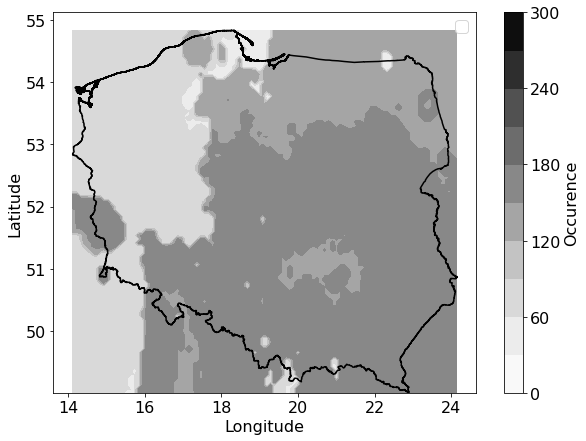

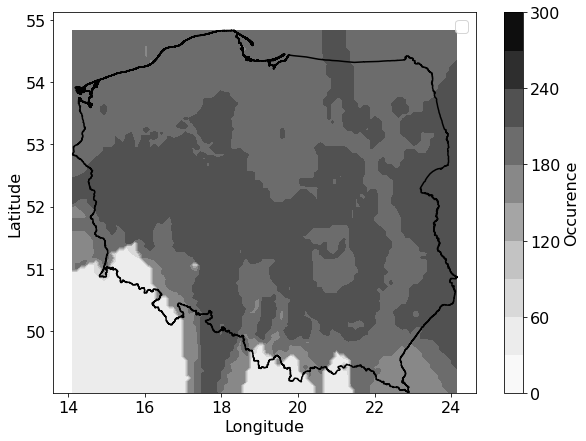

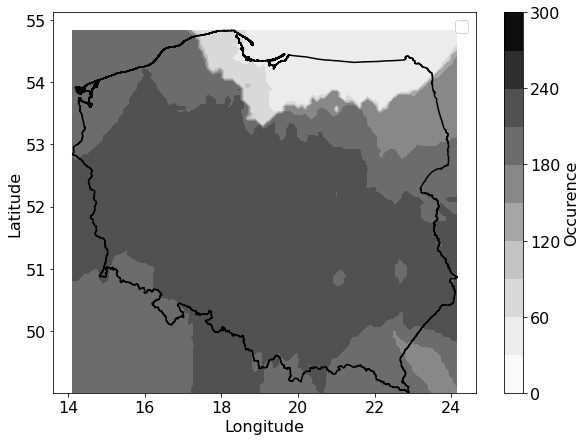

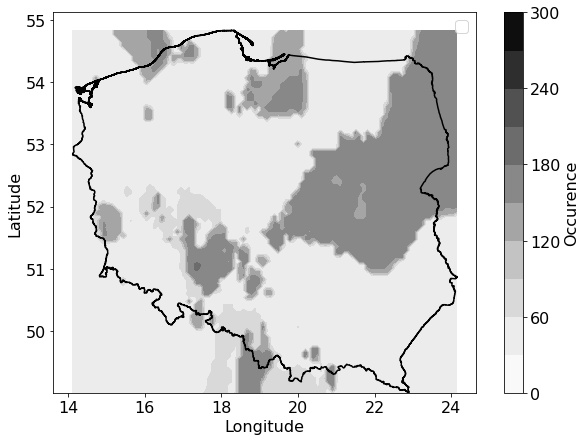

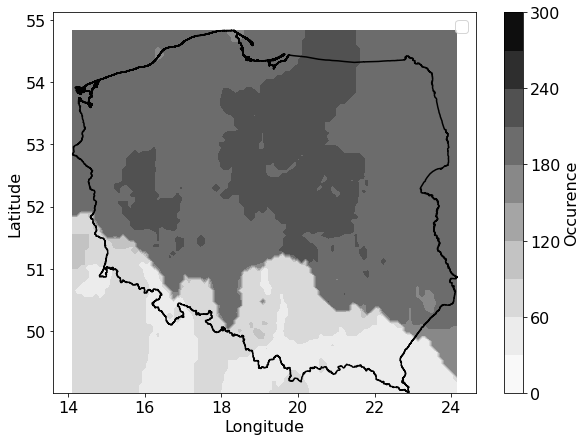

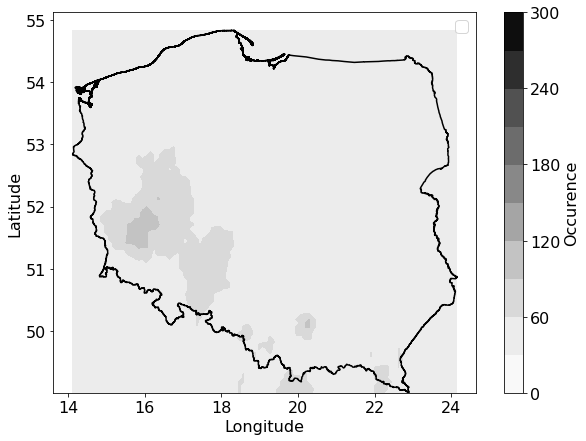

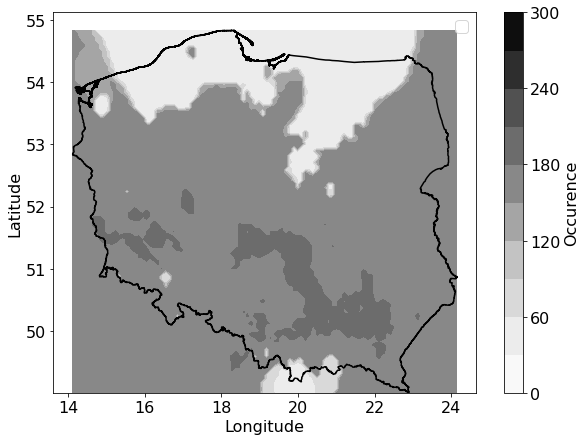

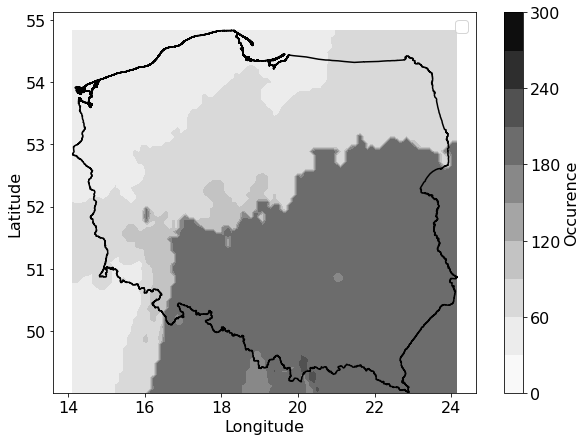

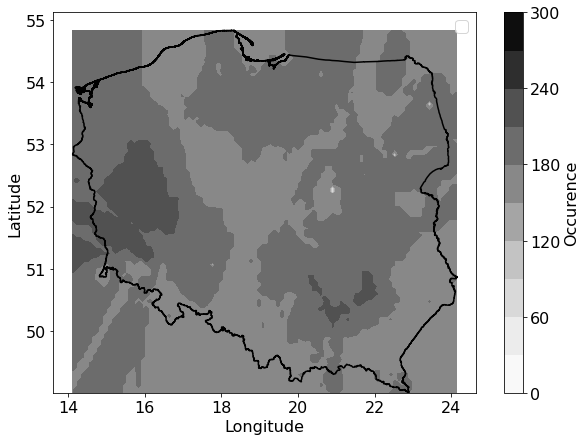

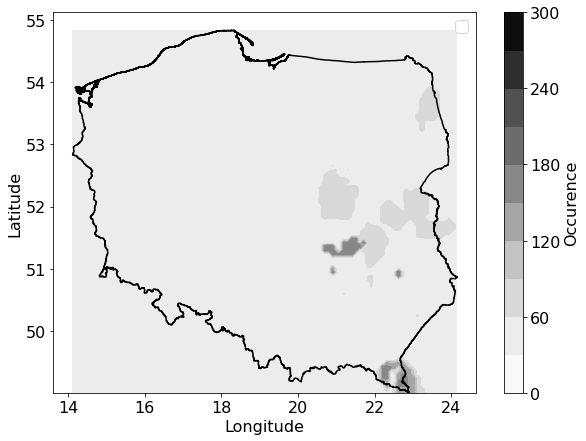

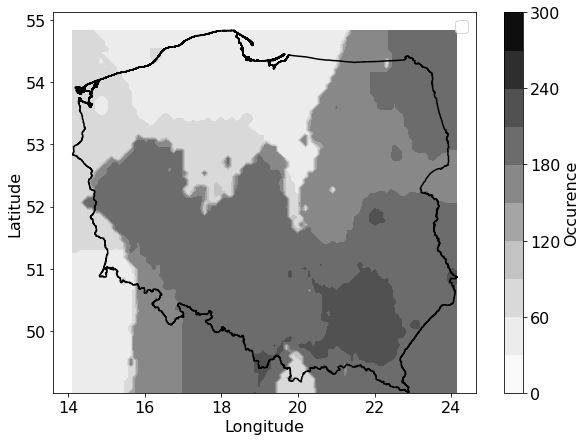

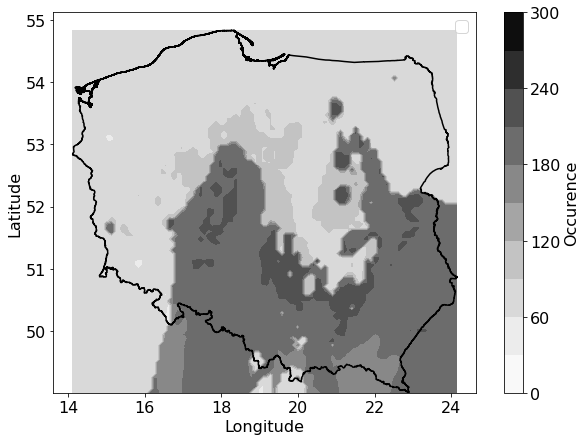

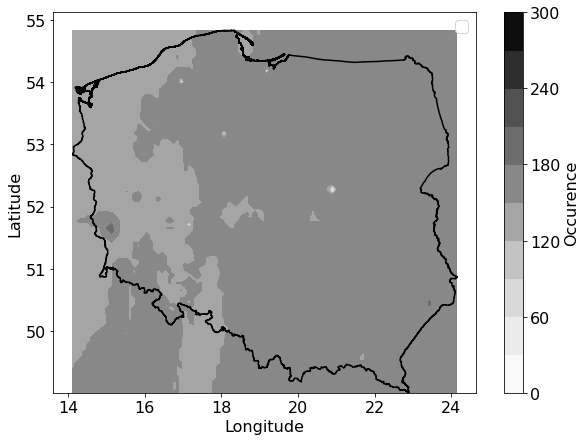

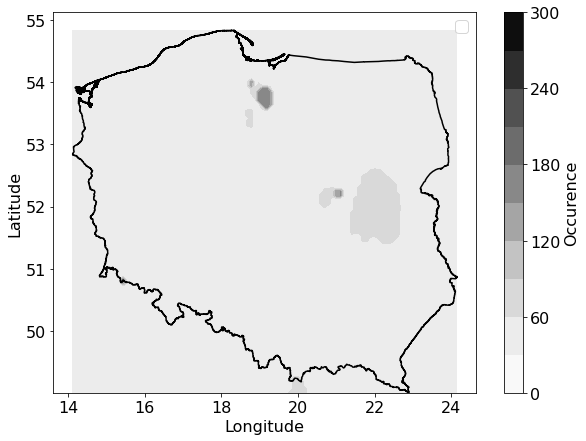

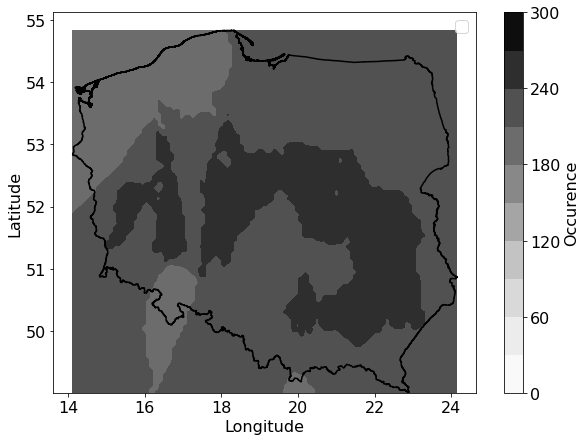

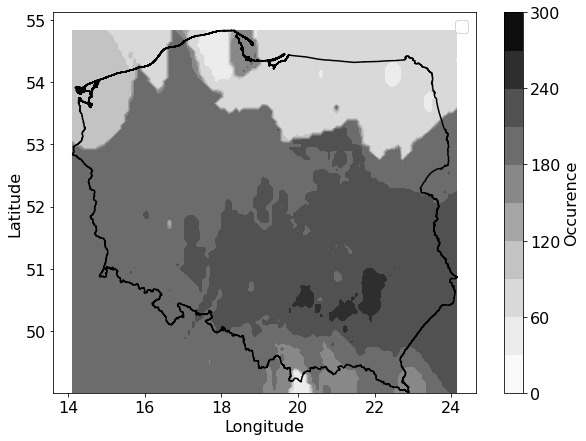

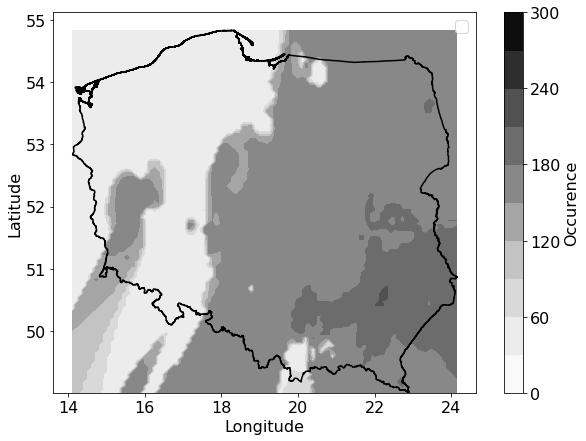

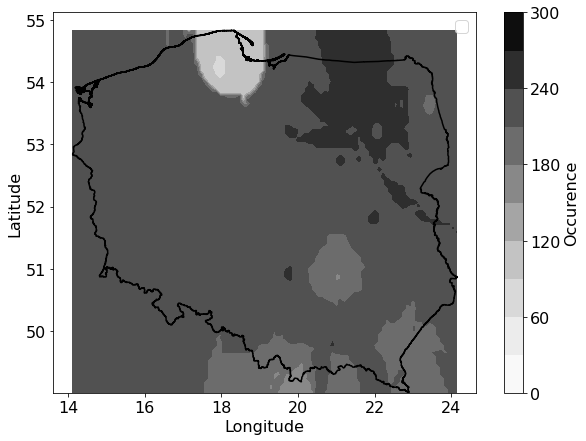

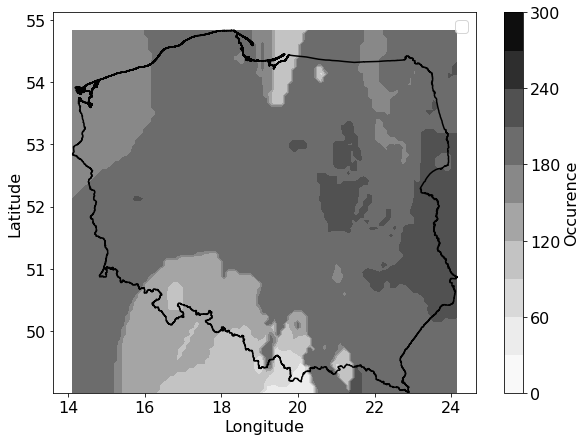

In [85]:
from shapely import speedups
from matplotlib.colors import Normalize
os.makedirs('maps_s_tritici', exist_ok=True)


for y in range(2002,2020+1): # zmień rok na 2015

    filt = ((grid_transformed_predictions['year'] == y) & 
            (grid_transformed_predictions['species'] == 0) &
            (grid_transformed_predictions['pathogen'] == 'summ_S_tritici'))
    predictions_filtered = grid_transformed_predictions[filt]

    X_grid = np.array(predictions_filtered[['E', 'N']])
    y_grid = np.array(predictions_filtered['predictions'])


    speedups.disable()

    pl = geopandas.read_file("maska_PL.gpkg")
    pl.boundary.plot(edgecolor="black", facecolor="none", figsize=(10,7))
    
    plt.ylabel("Latitude", fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.xticks(fontsize=16, 
#                rotation=90
              )
    plt.yticks(fontsize=16
#                , rotation=90
              )

    col_bar = plt.contourf(X_grid.T[0].reshape(100,100),  X_grid.T[1].reshape(100,100), y_grid.reshape(100,100), 
    cmap=plt.get_cmap("Greys"), 
     levels = np.linspace(0, 300, 11), 
#     vmin = 0, vmax = 250,
    norm = Normalize(vmin=0, vmax=300)
    )
    cmapp = plt.get_cmap('Greys')

    cbar = plt.colorbar(col_bar, cmap = cmapp)
    cbar.set_label('Occurence', fontsize=16)
    cbar.ax.tick_params(labelsize=16) 
    plt.legend(fontsize=16)
#             plt.show()
    plt.savefig(os.path.join('maps_s_tritici', 'map_%s_%s_%s.png' %(str(y), str(0), 'summ_S_tritici')), dpi = 300)

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-89-9d83d3709a8c>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(col_bar, cmap = cmapp)
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-89-9d83d3709a8c>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-89-9d83d3709a8c>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(col_bar, cmap = cmapp)
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-89-9d83d3709a8c>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases

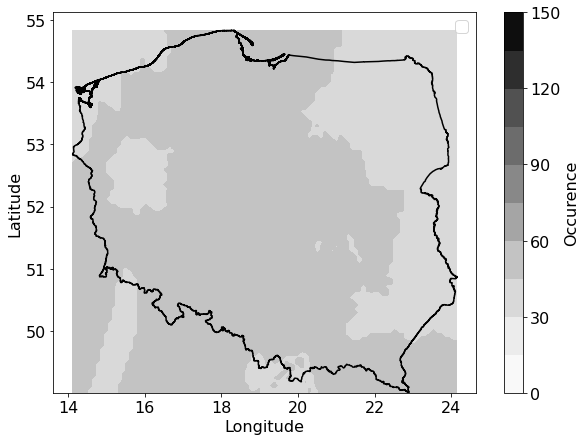

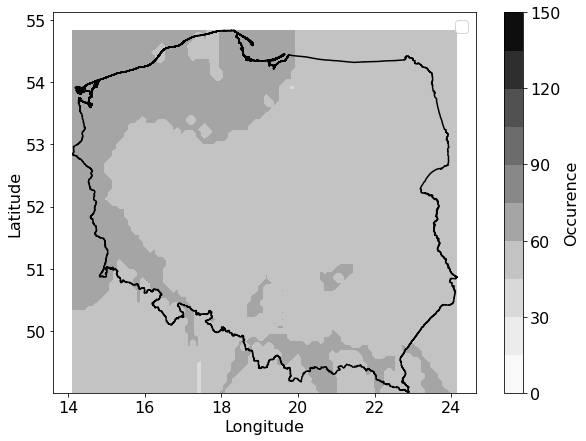

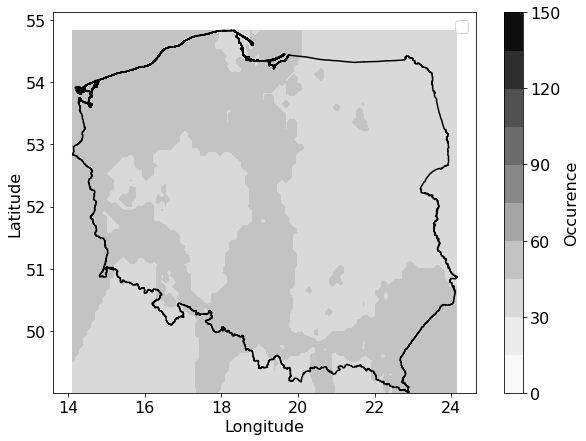

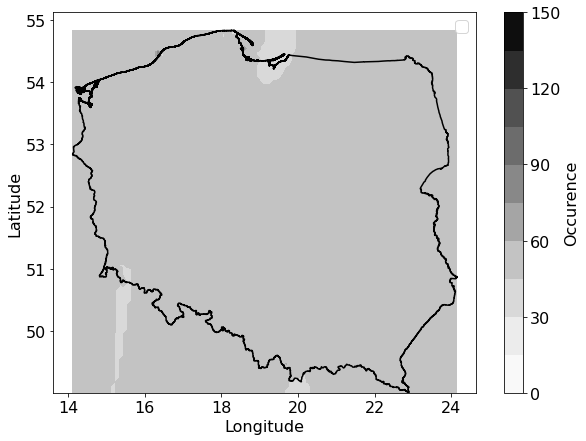

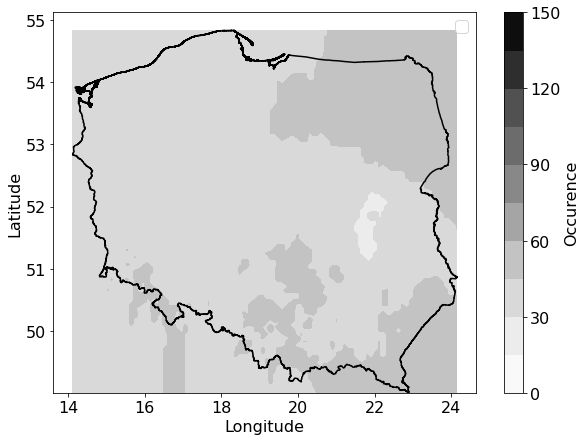

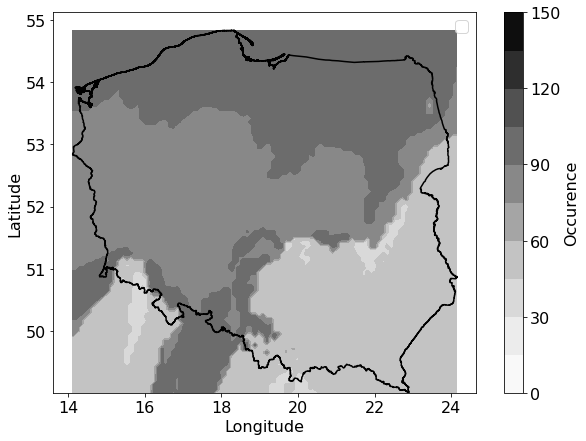

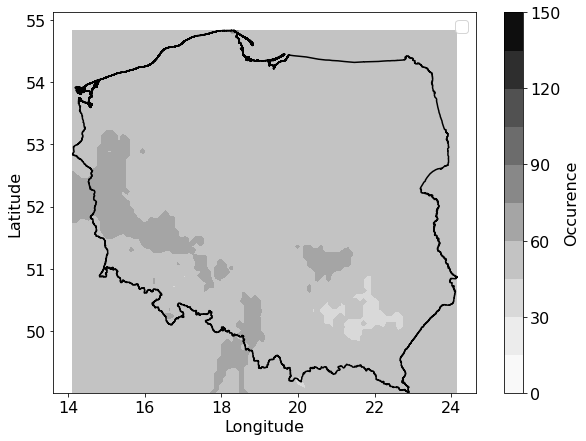

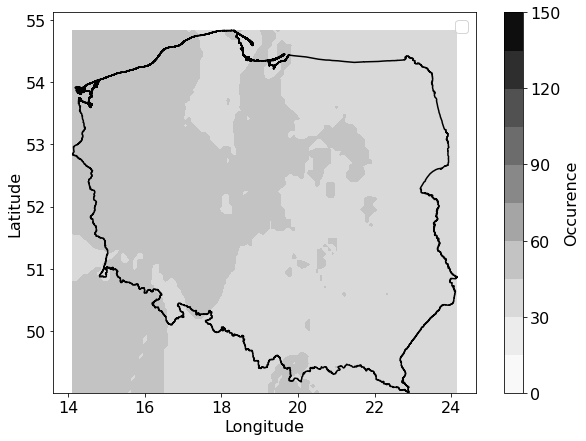

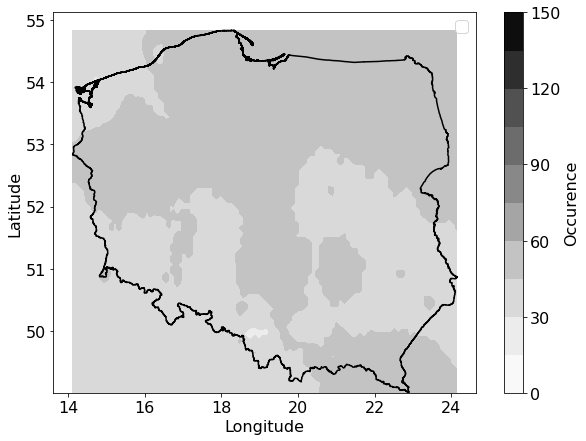

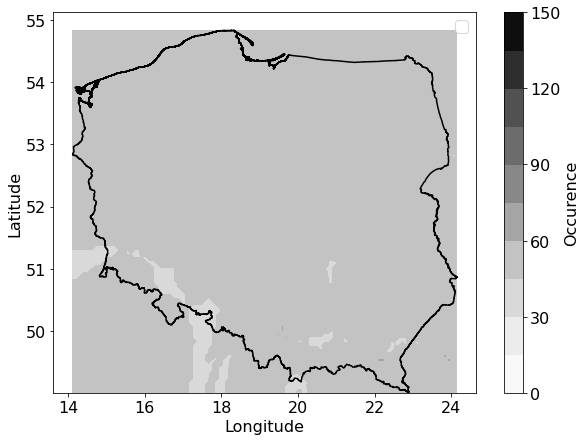

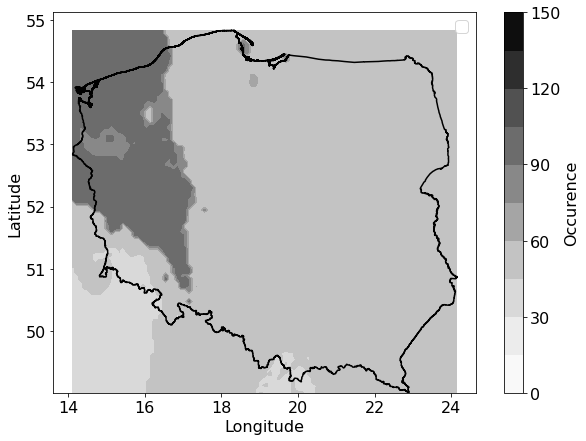

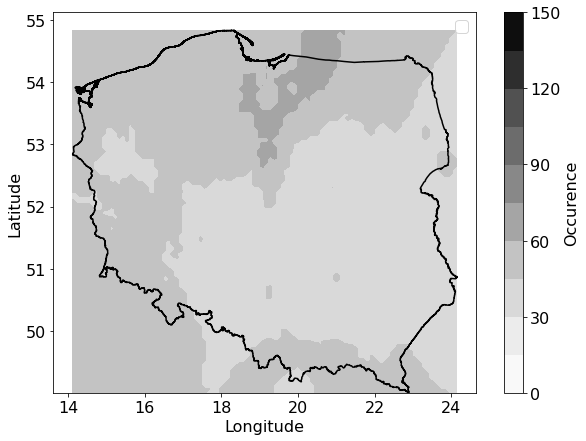

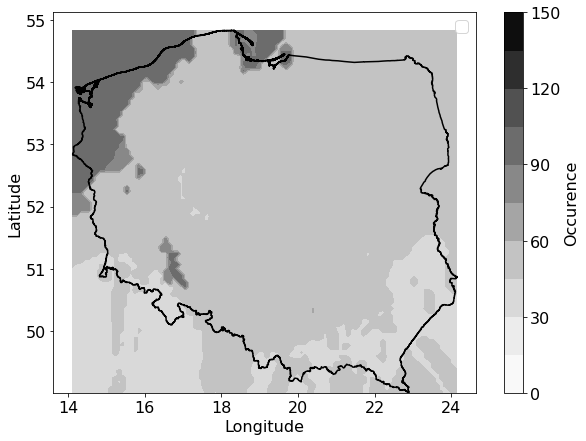

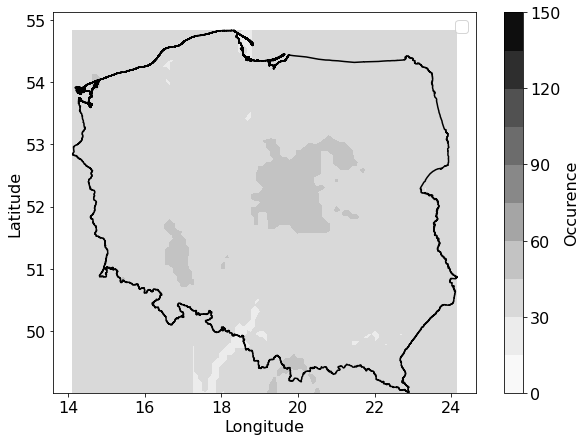

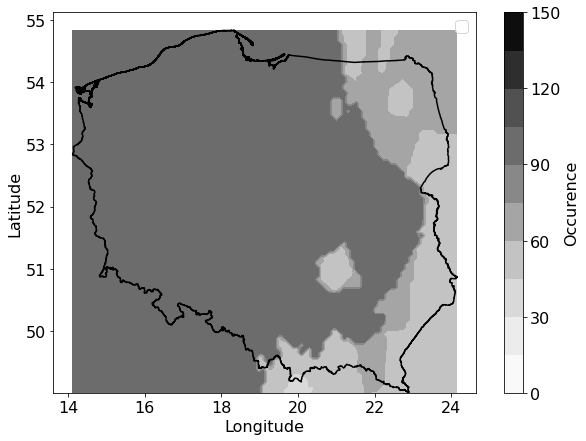

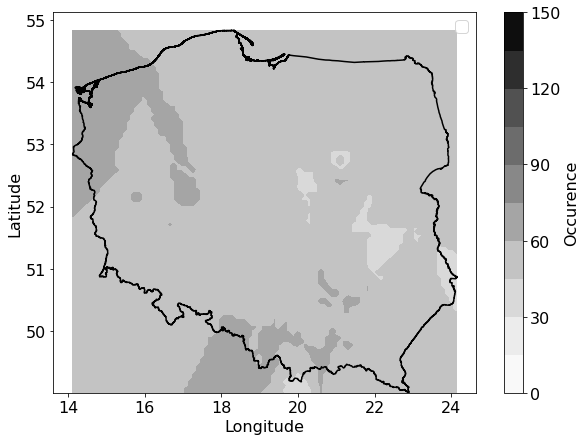

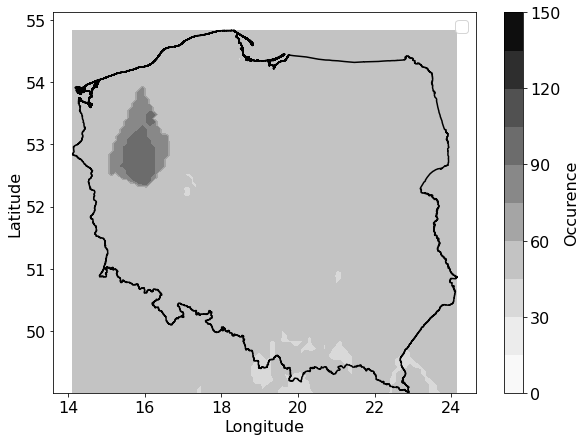

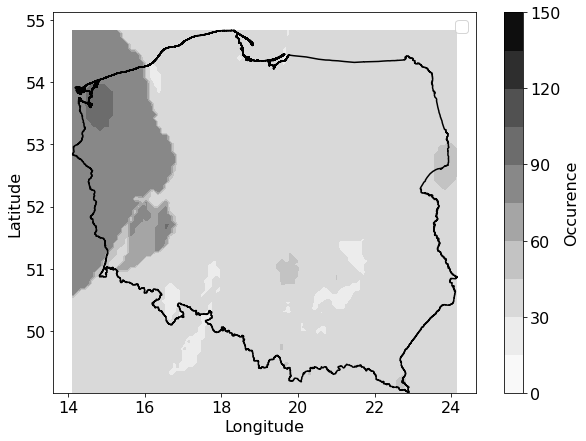

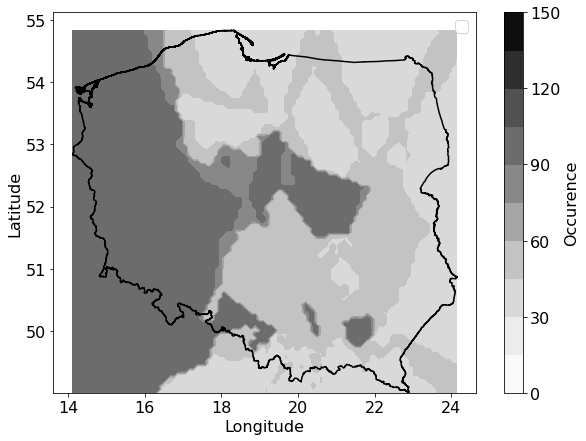

In [89]:
from shapely import speedups
import matplotlib.colors 
os.makedirs('maps_s_nodorum', exist_ok=True)

for y in range(2002,2020+1):

    filt = ((grid_transformed_predictions['year'] == y) & 
            (grid_transformed_predictions['species'] == 0) &
            (grid_transformed_predictions['pathogen'] == 'summ_S_nodorum'))
    predictions_filtered = grid_transformed_predictions[filt]

    X_grid = np.array(predictions_filtered[['E', 'N']])
    y_grid = np.array(predictions_filtered['predictions'])


    speedups.disable()

    pl = geopandas.read_file("maska_PL.gpkg")
    pl.boundary.plot(edgecolor="black", facecolor="none", figsize=(10,7))
    
    plt.ylabel("Latitude", fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.xticks(fontsize=16, 
#                rotation=90
              )
    plt.yticks(fontsize=16
#                , rotation=90
              )

    col_bar = plt.contourf(X_grid.T[0].reshape(100,100),  X_grid.T[1].reshape(100,100), y_grid.reshape(100,100), 
    cmap=plt.get_cmap("Greys"), 
     levels = np.linspace(0, 150, 11), 
#     vmin = 0, vmax = 250,
    norm = Normalize(vmin=0, vmax=150)
    )
    cmapp = plt.get_cmap('Greys')

    cbar = plt.colorbar(col_bar, cmap = cmapp)
    cbar.set_label('Occurence', fontsize=16)
    cbar.ax.tick_params(labelsize=16) 
    plt.legend(fontsize=16)
#             plt.show()
    plt.savefig(os.path.join('maps_s_nodorum', 'map_%s_%s_%s.png' %(str(y), str(0), 'summ_S_nodorum')), dpi = 300)

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-86-ce3ac6cd5a2f>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(col_bar, cmap = cmapp)
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-86-ce3ac6cd5a2f>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-86-ce3ac6cd5a2f>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(col_bar, cmap = cmapp)
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-86-ce3ac6cd5a2f>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases

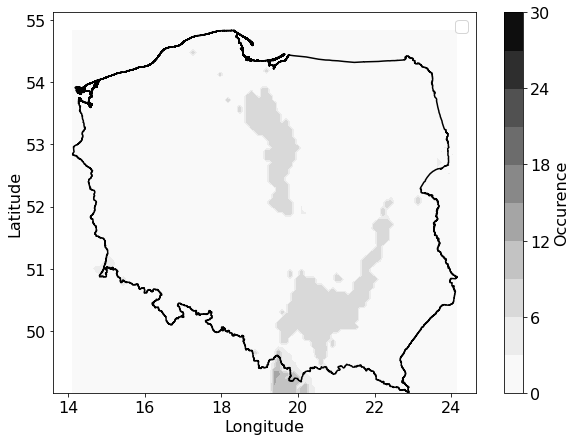

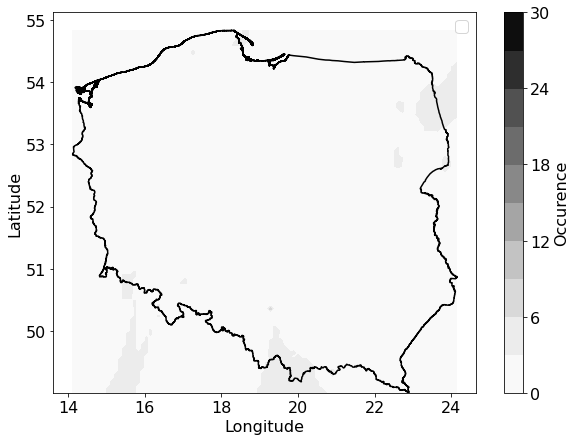

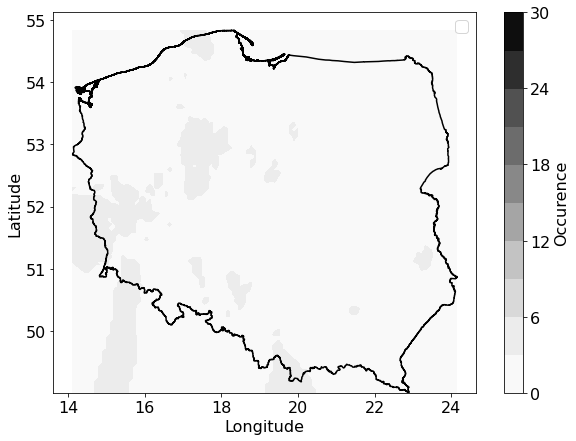

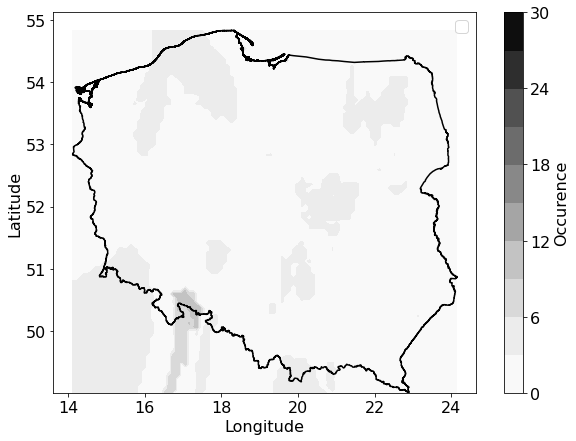

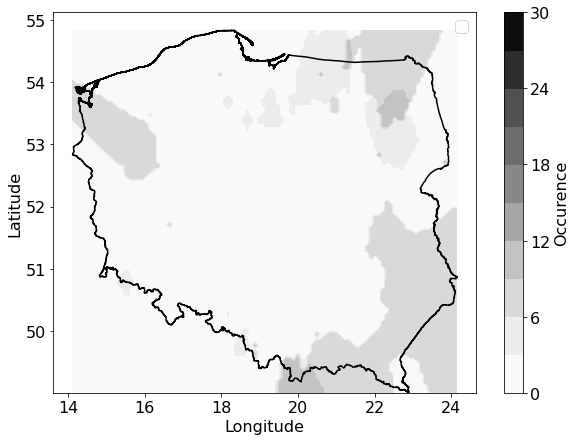

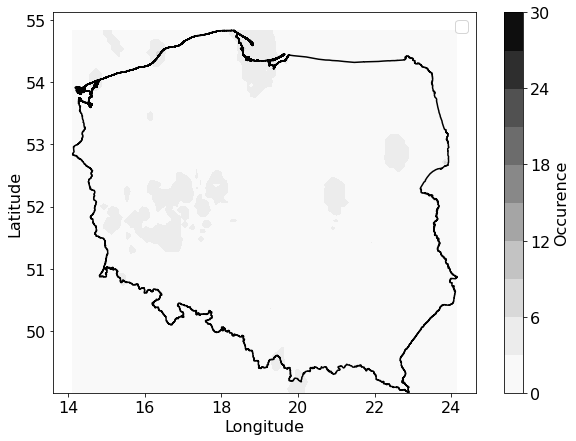

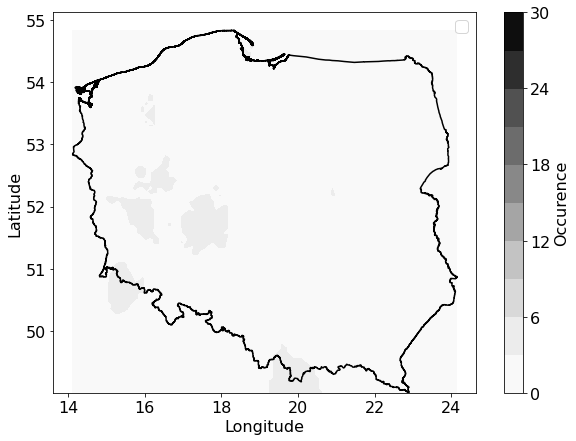

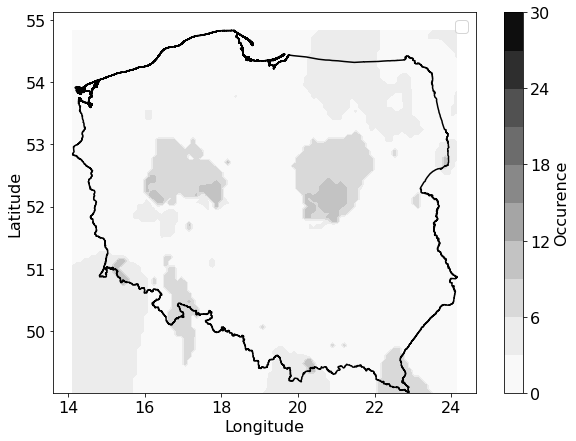

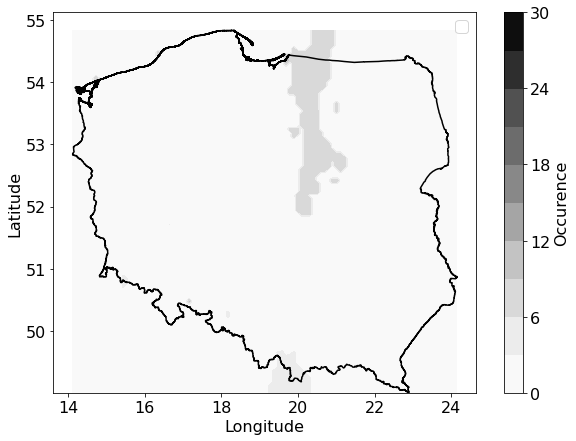

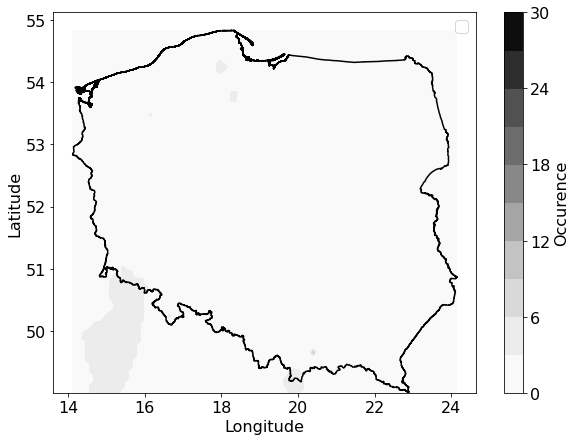

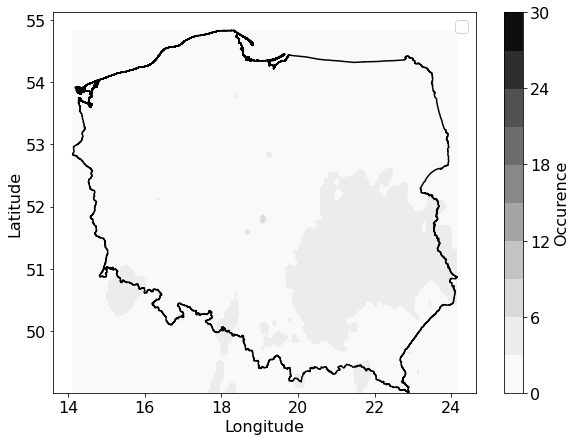

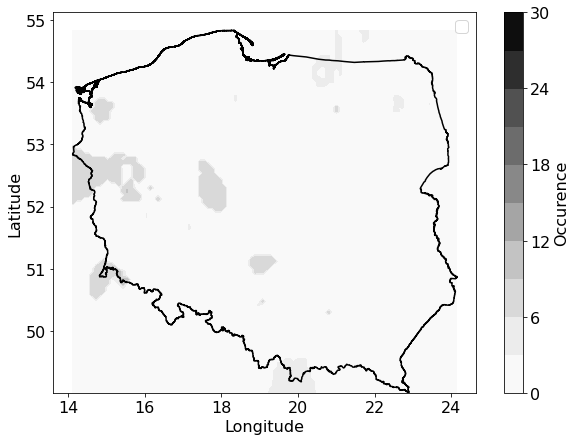

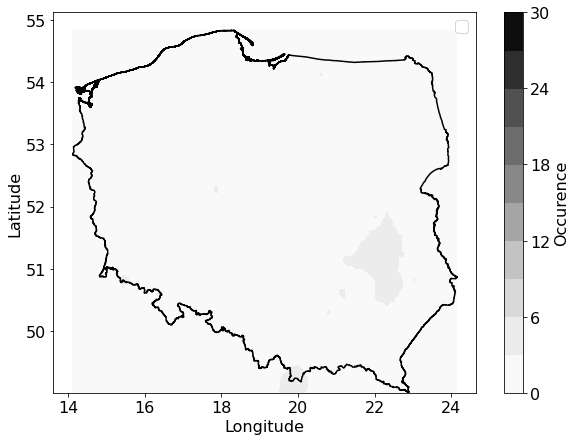

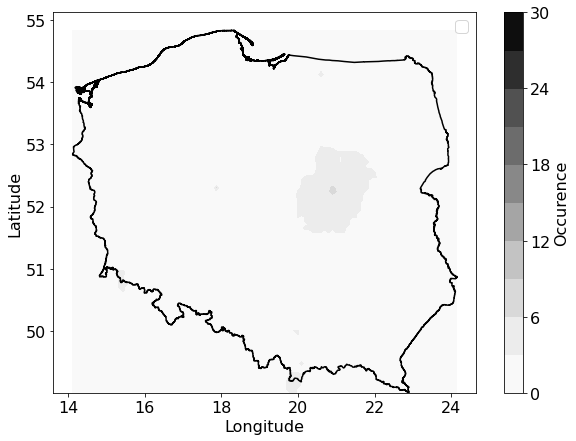

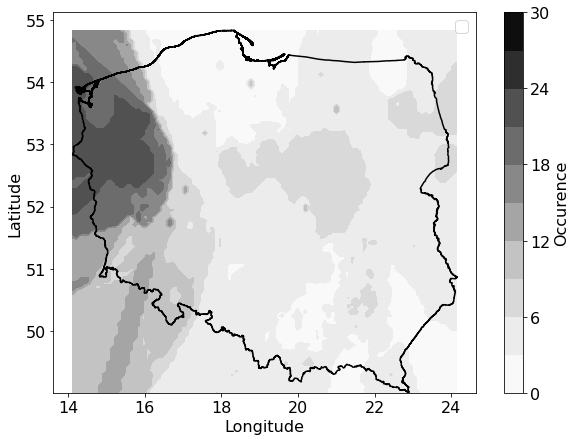

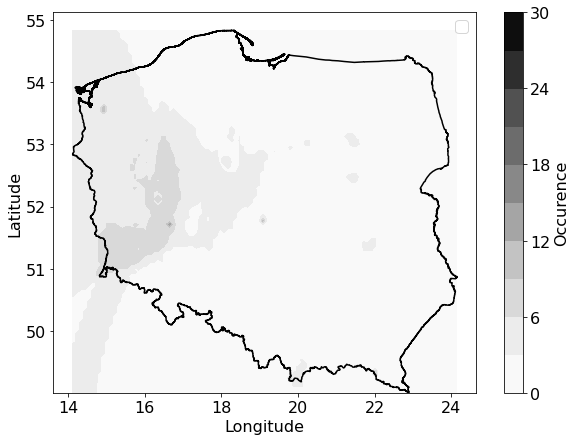

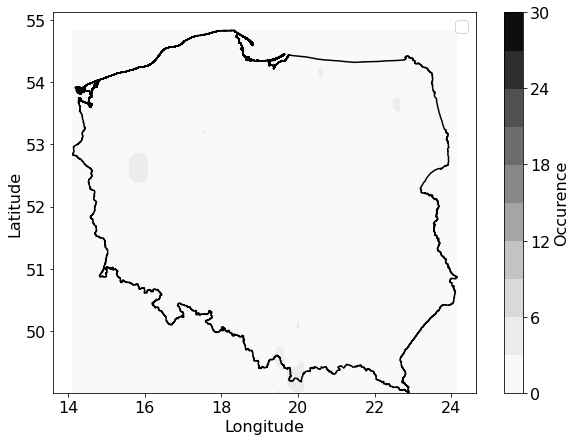

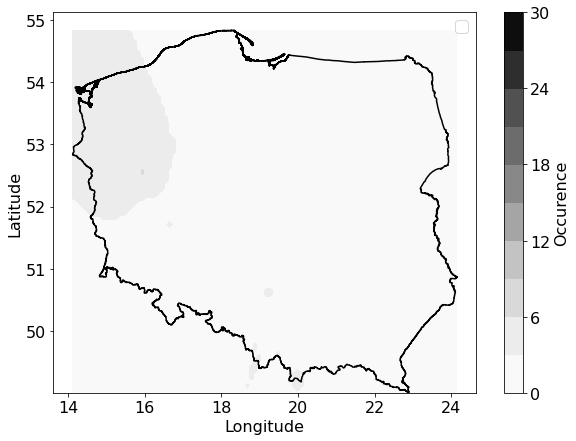

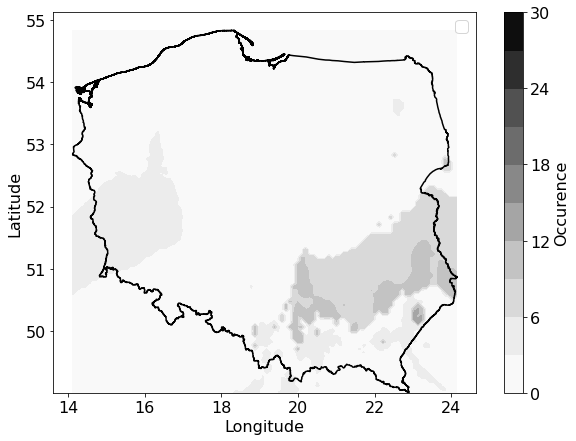

In [86]:
from shapely import speedups
import matplotlib.colors 
os.makedirs('maps_s_avenae_wheat', exist_ok=True)

for y in range(2002,2020+1):

    filt = ((grid_transformed_predictions['year'] == y) & 
            (grid_transformed_predictions['species'] == 0) &
            (grid_transformed_predictions['pathogen'] == 'summ_S_avenae'))
    predictions_filtered = grid_transformed_predictions[filt]

    X_grid = np.array(predictions_filtered[['E', 'N']])
    y_grid = np.array(predictions_filtered['predictions'])


    speedups.disable()

    pl = geopandas.read_file("maska_PL.gpkg")
    pl.boundary.plot(edgecolor="black", facecolor="none", figsize=(10,7))
    
    plt.ylabel("Latitude", fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.xticks(fontsize=16, 
#                rotation=90
              )
    plt.yticks(fontsize=16
#                , rotation=90
              )

    col_bar = plt.contourf(X_grid.T[0].reshape(100,100),  X_grid.T[1].reshape(100,100), y_grid.reshape(100,100), 
    cmap=plt.get_cmap("Greys"), 
     levels = np.linspace(0, 30, 11), 
#     vmin = 0, vmax = 250,
    norm = Normalize(vmin=0, vmax=30)
    )
    cmapp = plt.get_cmap('Greys')

    cbar = plt.colorbar(col_bar, cmap = cmapp)
    cbar.set_label('Occurence', fontsize=16)
    cbar.ax.tick_params(labelsize=16) 
    plt.legend(fontsize=16)
#             plt.show()
    plt.savefig(os.path.join('maps_s_avenae_wheat', 'map_%s_%s_%s.png' %(str(y), str(0), 'summ_S_avenae')), dpi = 300)

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-87-c58dddafe0c9>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(col_bar, cmap = cmapp)
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-87-c58dddafe0c9>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases

No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-87-c58dddafe0c9>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(col_bar, cmap = cmapp)
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-87-c58dddafe0c9>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated s

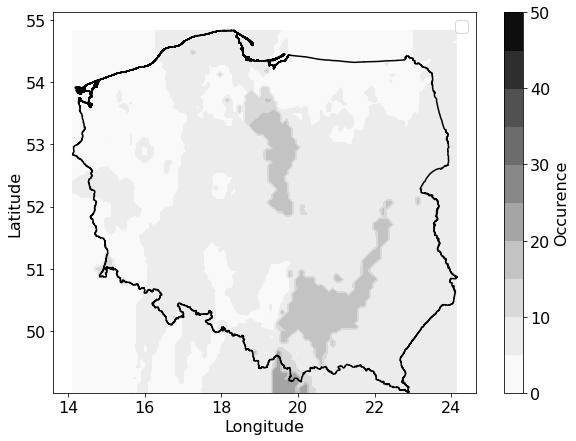

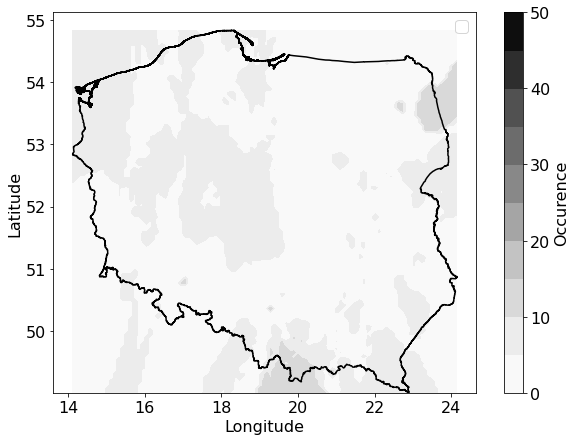

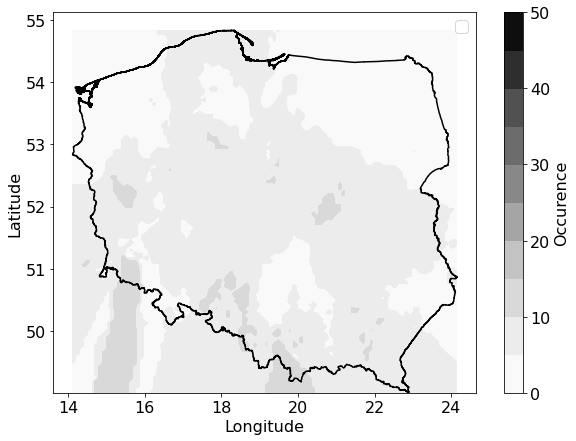

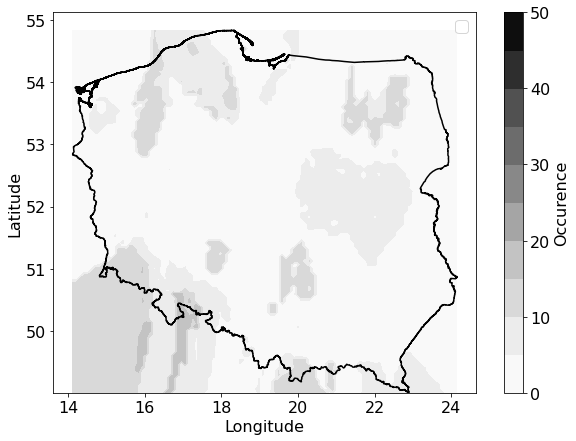

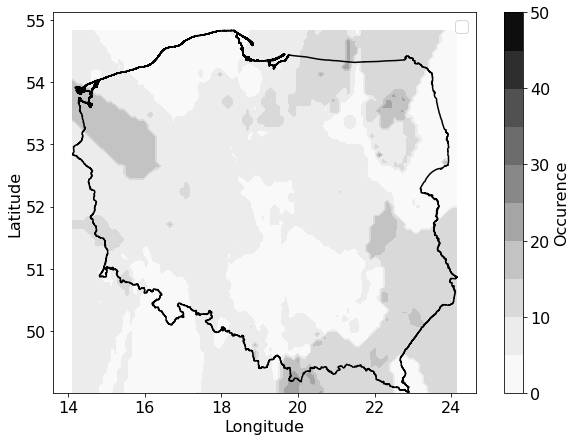

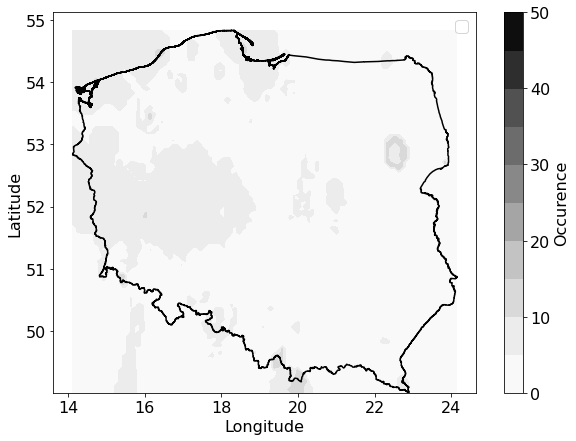

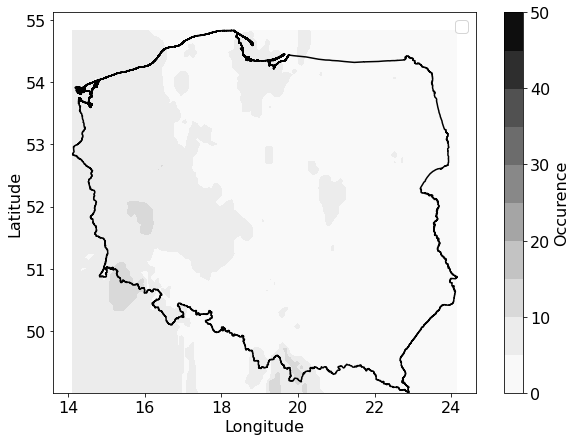

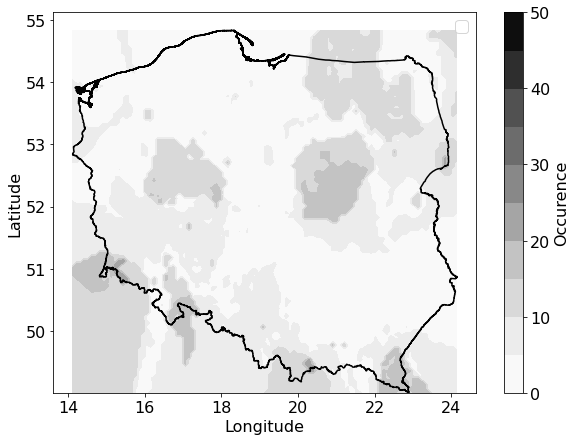

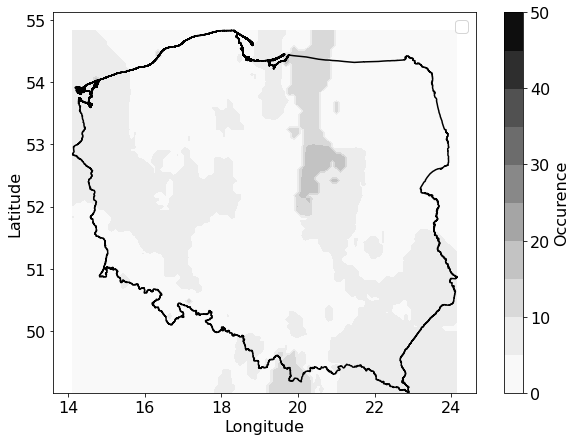

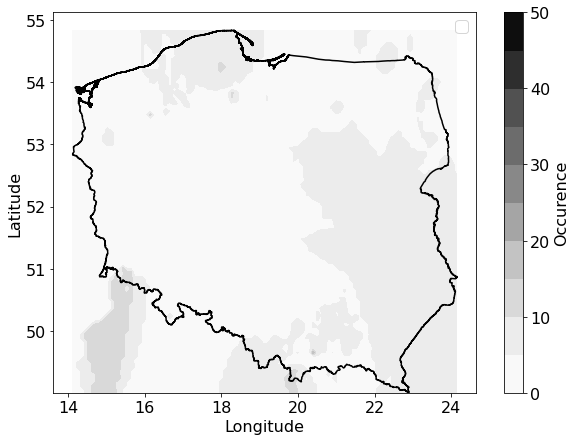

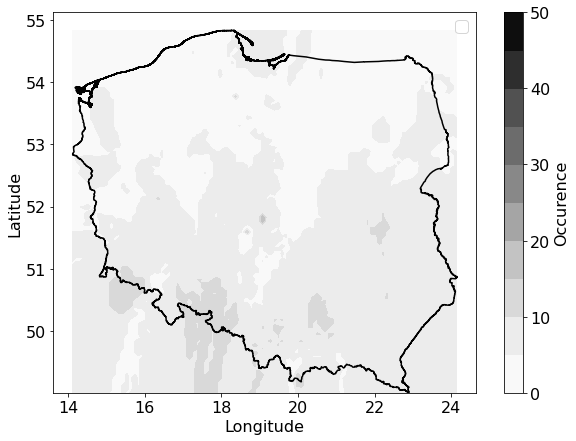

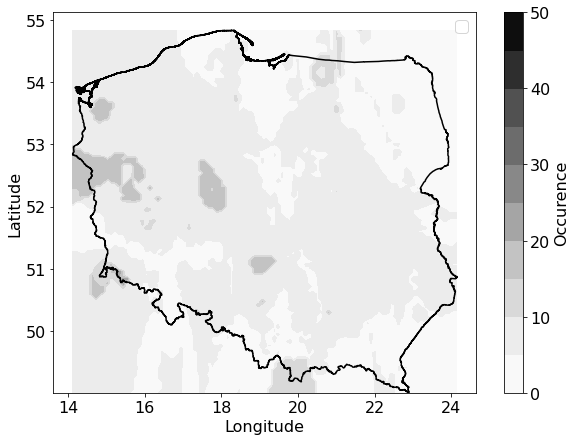

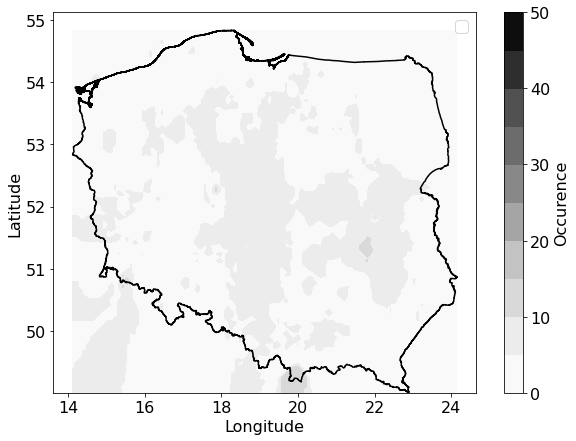

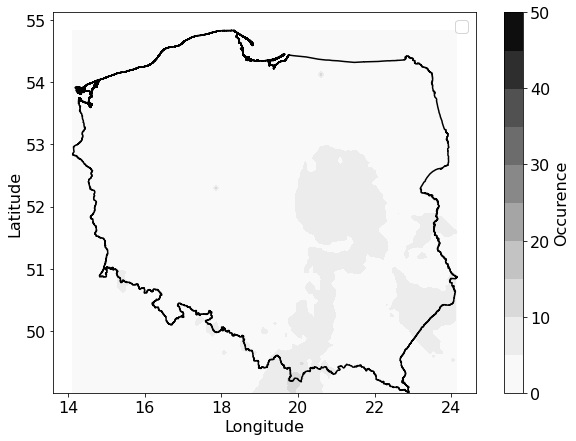

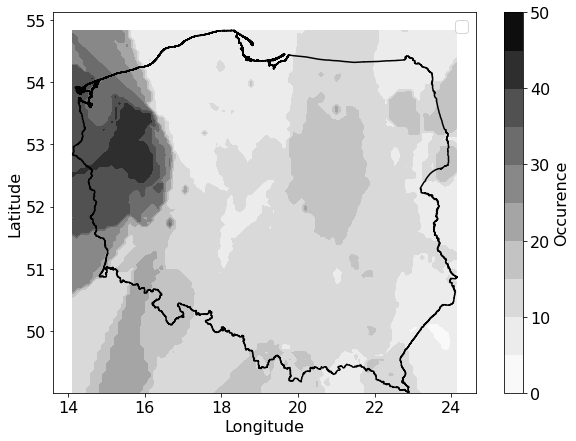

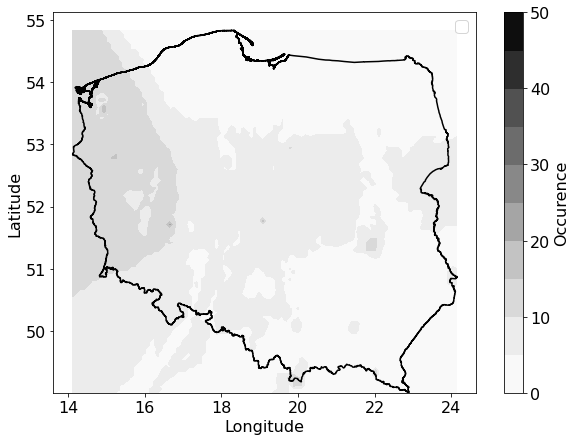

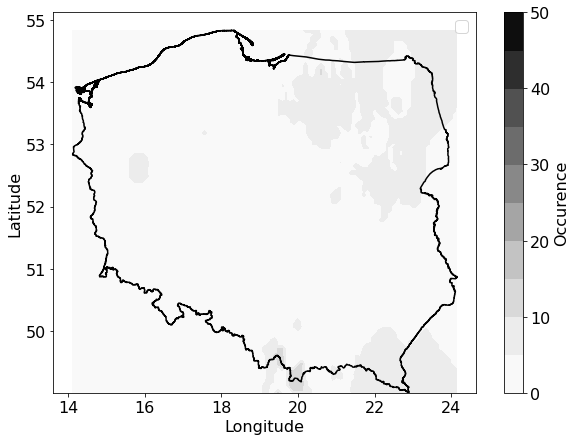

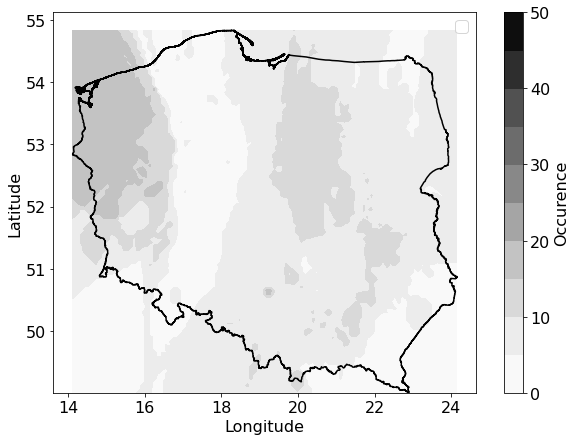

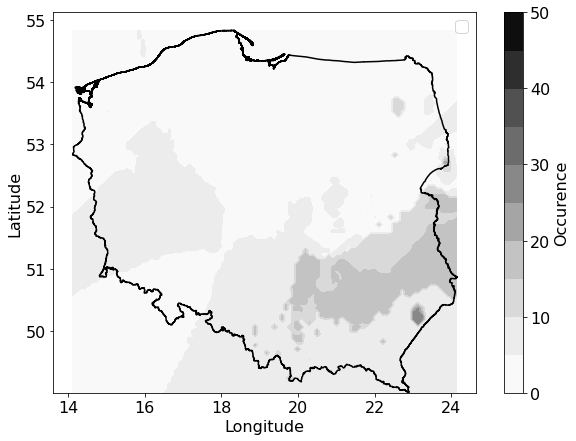

In [87]:
from shapely import speedups
import matplotlib.colors 
os.makedirs('maps_s_avenae_triticale', exist_ok=True)

for y in range(2002,2020+1):

    filt = ((grid_transformed_predictions['year'] == y) & 
            (grid_transformed_predictions['species'] == 1) &
            (grid_transformed_predictions['pathogen'] == 'summ_S_avenae'))
    predictions_filtered = grid_transformed_predictions[filt]

    X_grid = np.array(predictions_filtered[['E', 'N']])
    y_grid = np.array(predictions_filtered['predictions'])


    speedups.disable()

    pl = geopandas.read_file("maska_PL.gpkg")
    pl.boundary.plot(edgecolor="black", facecolor="none", figsize=(10,7))
    
    plt.ylabel("Latitude", fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.xticks(fontsize=16, 
#                rotation=90
              )
    plt.yticks(fontsize=16
#                , rotation=90
              )

    col_bar = plt.contourf(X_grid.T[0].reshape(100,100),  X_grid.T[1].reshape(100,100), y_grid.reshape(100,100), 
    cmap=plt.get_cmap("Greys"), 
     levels = np.linspace(0, 50, 11), 
#     vmin = 0, vmax = 250,
    norm = Normalize(vmin=0, vmax=50)
    )
    cmapp = plt.get_cmap('Greys')

    cbar = plt.colorbar(col_bar, cmap = cmapp)
    cbar.set_label('Occurence', fontsize=16)
    cbar.ax.tick_params(labelsize=16) 
    plt.legend(fontsize=16)
#             plt.show()
    plt.savefig(os.path.join('maps_s_avenae_triticale', 'map_%s_%s_%s.png' %(str(y), str(0), 'summ_S_avenae')), dpi = 300)

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-88-5c7894f631b0>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(col_bar, cmap = cmapp)
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-88-5c7894f631b0>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-88-5c7894f631b0>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(col_bar, cmap = cmapp)
No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
<ipython-input-88-5c7894f631b0>:38: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases

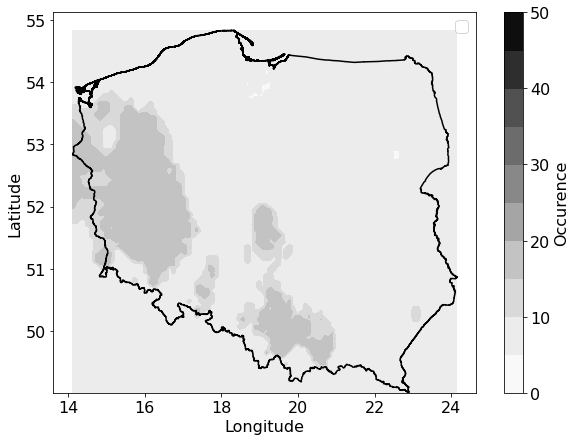

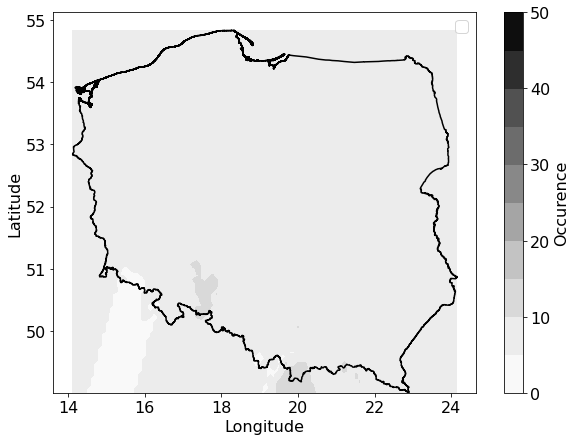

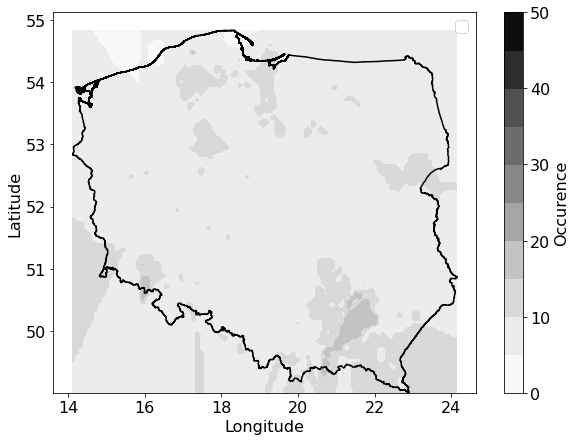

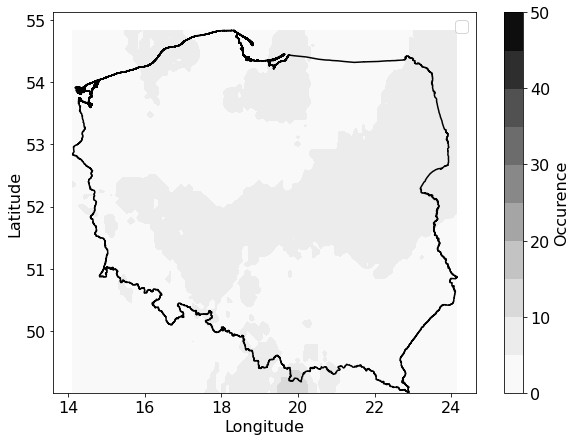

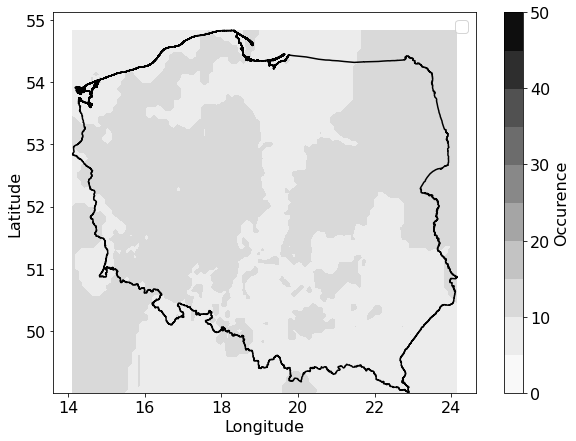

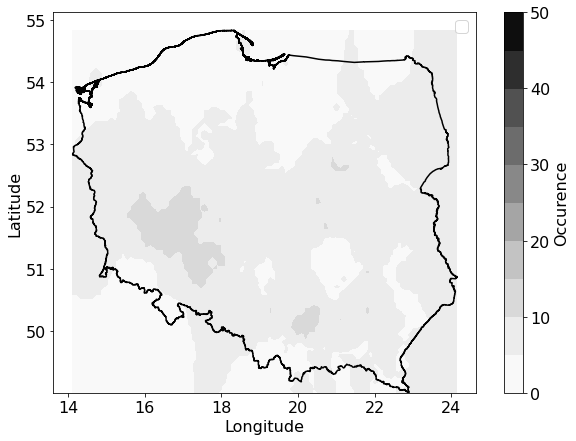

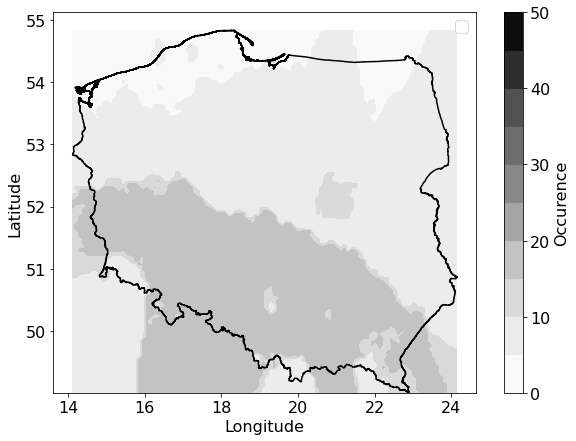

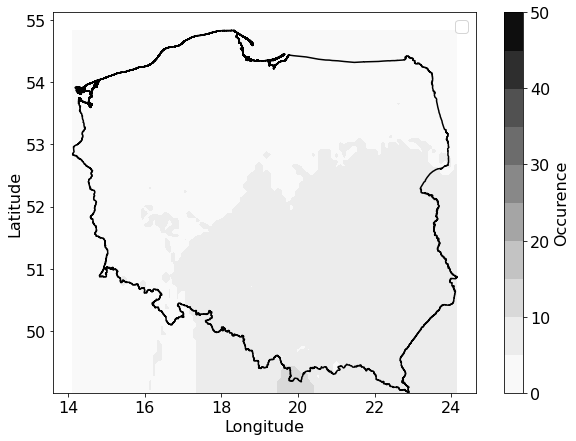

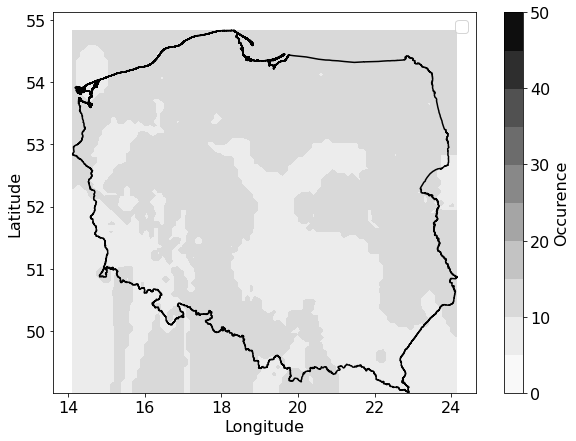

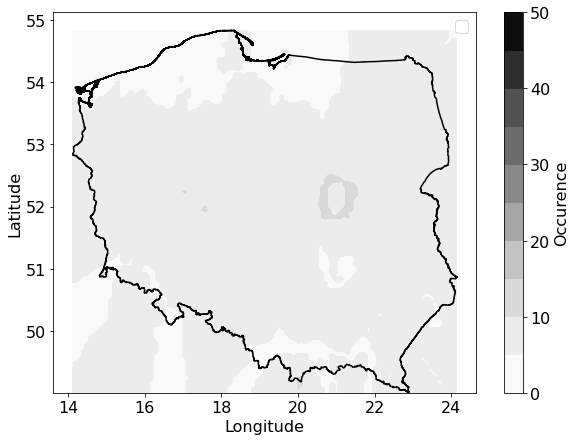

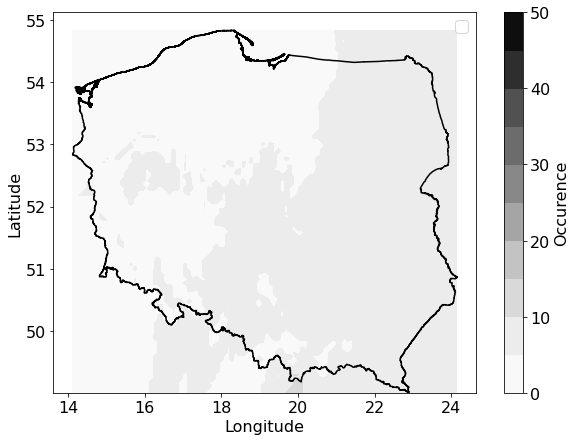

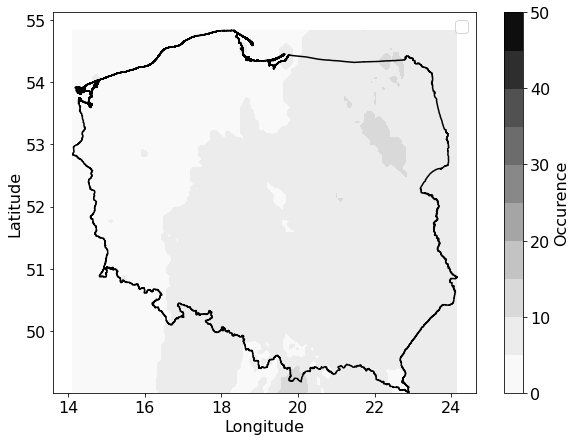

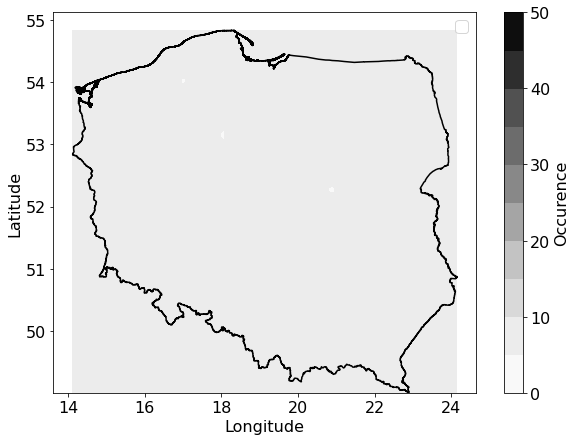

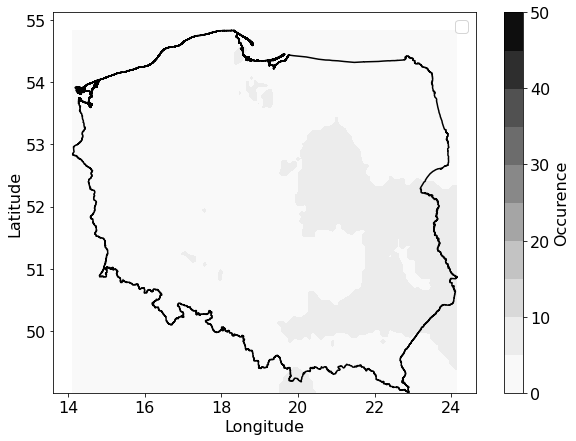

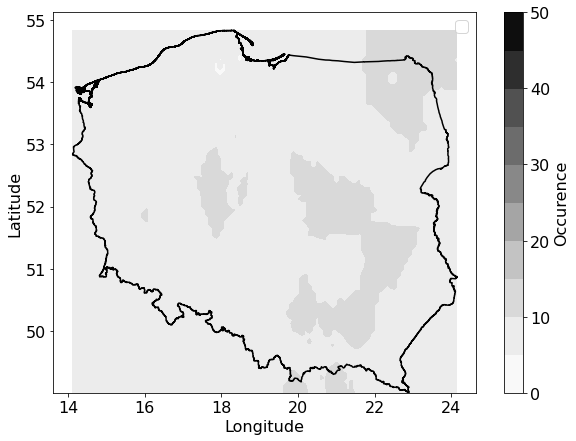

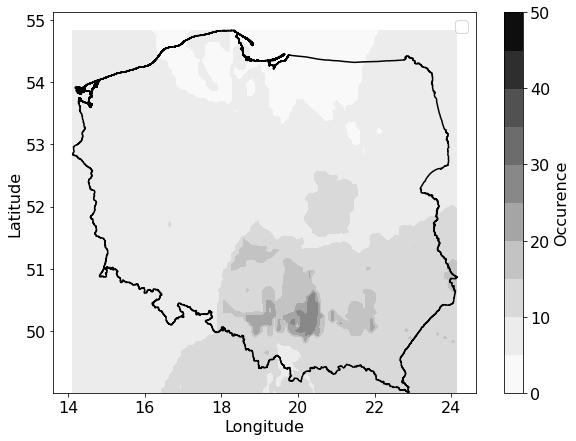

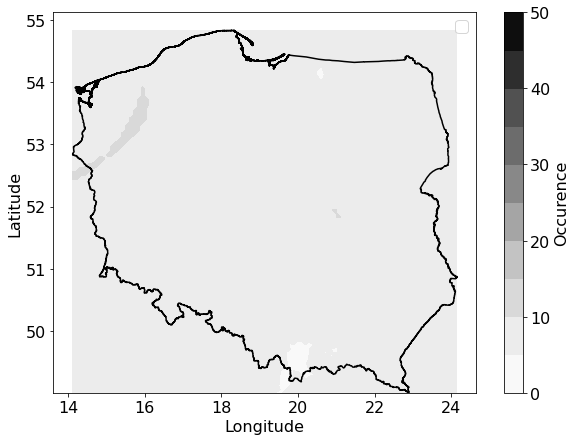

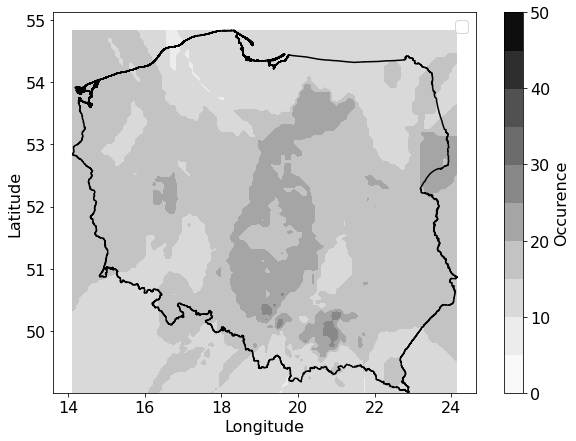

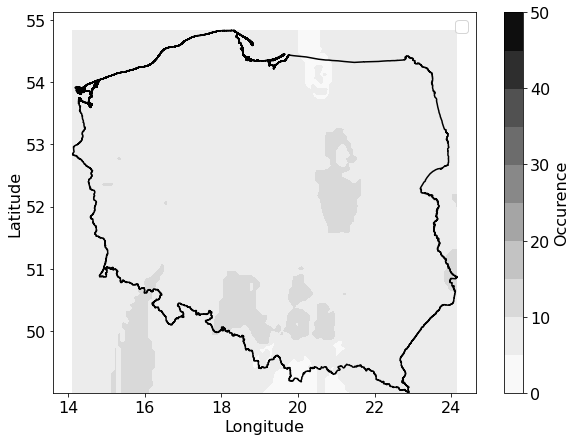

In [88]:
from shapely import speedups
import matplotlib.colors 
os.makedirs('maps_s_tritici_triticale', exist_ok=True)

for y in range(2002,2020+1):

    filt = ((grid_transformed_predictions['year'] == y) & 
            (grid_transformed_predictions['species'] == 1) &
            (grid_transformed_predictions['pathogen'] == 'summ_S_tritici'))
    predictions_filtered = grid_transformed_predictions[filt]

    X_grid = np.array(predictions_filtered[['E', 'N']])
    y_grid = np.array(predictions_filtered['predictions'])


    speedups.disable()

    pl = geopandas.read_file("maska_PL.gpkg")
    pl.boundary.plot(edgecolor="black", facecolor="none", figsize=(10,7))
    
    plt.ylabel("Latitude", fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.xticks(fontsize=16, 
#                rotation=90
              )
    plt.yticks(fontsize=16
#                , rotation=90
              )

    col_bar = plt.contourf(X_grid.T[0].reshape(100,100),  X_grid.T[1].reshape(100,100), y_grid.reshape(100,100), 
    cmap=plt.get_cmap("Greys"), 
     levels = np.linspace(0, 50, 11), 
#     vmin = 0, vmax = 250,
    norm = Normalize(vmin=0, vmax=50)
    )
    cmapp = plt.get_cmap('Greys')

    cbar = plt.colorbar(col_bar, cmap = cmapp)
    cbar.set_label('Occurence', fontsize=16)
    cbar.ax.tick_params(labelsize=16) 
    plt.legend(fontsize=16)
#             plt.show()
    plt.savefig(os.path.join('maps_s_tritici_triticale', 'map_%s_%s_%s.png' %(str(y), str(0), 'summ_S_tritici')), dpi = 300)